# **БИБЛИОТЕКИ**

In [ ]:
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.models import Model
from keras.applications import VGG16
# from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate, Activation, Lambda, BatchNormalization

import os
import cv2
import keras
import joblib
import numpy as np
import tensorflow as tf

from os import listdir
# from google.colab import files
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow

In [ ]:
# import zipfile
# with zipfile.ZipFile('right/right-20240227T115433Z-001.zip', 'r') as zip_ref:
#     zip_ref.extractall('right/right')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **ФУНКЦИИ**

In [ ]:
# Функция для генерации якорных рамок
def generate_anchors(size):

    aspect_ratios = [1, 0.5, 2]
    scales = [64, 128] #256
    step = 32 #224 / 7

    anchors = []

    points = []
    for i in range(size[0]):
        for j in range(size[1]):
            if i % step == 0 and j % step == 0 and i != 0 and j != 0:
                points.append([i, j])

    cc = 0
    for i in range(36):
        for scale in scales:
            for ratio in aspect_ratios:
                w = np.sqrt(scale * scale / ratio)
                h = w * ratio
                anchors.append([-w / 2 + points[cc][0], -h / 2 + points[cc][1], w / 2 + points[cc][0], h / 2 + points[cc][1]])
        cc += 1

    indices = []
    for i in range(len(anchors)):
        for j in range(len(anchors[0])):
            if anchors[i][j] > size[0] or anchors[i][j] < 0:
                indices.append(i)
                break

    for i in sorted(indices, reverse=True):
        del anchors[i]

    return np.array(anchors)

# Параметры для генерации якорных рамок

# Генерация якорных рамок
ss = (224, 224)
anchors = generate_anchors(ss)

print(anchors.shape)
#print(anchors)


(116, 4)


In [ ]:
def IoU(box1, box2):
    # Получаем координаты левого верхнего и правого нижнего углов для каждого прямоугольника
    x1_box1, y1_box1, x2_box1, y2_box1 = box1
    x1_box2, y1_box2, x2_box2, y2_box2 = box2

    # Вычисляем площади прямоугольников
    area_box1 = (x2_box1 - x1_box1 + 1) * (y2_box1 - y1_box1 + 1)
    area_box2 = (x2_box2 - x1_box2 + 1) * (y2_box2 - y1_box2 + 1)

    # Вычисляем координаты верхней левой точки и нижней правой точки для пересечения прямоугольников
    x1_intersection = max(x1_box1, x1_box2)
    y1_intersection = max(y1_box1, y1_box2)
    x2_intersection = min(x2_box1, x2_box2)
    y2_intersection = min(y2_box1, y2_box2)

    # Вычисляем площадь пересечения прямоугольников
    width_intersection = max(0, x2_intersection - x1_intersection + 1)
    height_intersection = max(0, y2_intersection - y1_intersection + 1)
    area_intersection = width_intersection * height_intersection

    # Вычисляем площадь объединения прямоугольников
    area_union = area_box1 + area_box2 - area_intersection

    # Вычисляем IoU
    iou = float(area_intersection) / float(area_union)

    return iou

# Пример использования
# box1 = (25, 25, 70, 50)
# box2 = (50, 37, 100, 85)
# iou = IoU(box1, box2)
# print(iou)

In [ ]:
def NMS(dets, thresh=0.7):
    # x1, y1, x2, y2 и присвоение очков
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]
    # Площадь каждого кадра обнаружения
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    # Сортировано в порядке убывания по достоверности оценок
    order = scores.argsort()[::-1]
    # Зарезервированная коллекция окна результатов
    keep = []
    while order.size > 0:
        i = order[0]
        # Оставьте наивысший балл в оставшихся полях этой категории
        keep.append(i)
        # Получить область пересечения, верхний левый и нижний правый
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        # Рассчитать площадь перекрестка, площадь равна 0, когда нет перекрытия
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        #Calculate IoU: область перекрытия / (область 1 + область 2 - область перекрытия)
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        # Держите коробку с IoU ниже порога
        inds = np.where(ovr <= thresh)[0]
        # Поскольку длина массива ovr на единицу меньше, чем массив порядка, все индексы здесь сдвигаются назад на единицу
        order = order[inds + 1]

        return keep


# **ФОРМИРОВАНИЕ ДАННЫХ**

In [ ]:
#ФОРМИРОВАНИЕ X_TRAIN
f1 = open("/content/gdrive/MyDrive/Colab Notebooks/RPN/train/_annotations.txt", 'r')

folder_dir = "/content/gdrive/MyDrive/Colab Notebooks/RPN/train"

x_train_img = []

count = 0

for i in f1:

    image_1 = i.split()[0]

    for image_2 in os.listdir(folder_dir):
        if image_2.endswith(".jpg"):
            if image_1 == image_2:
                img1 = cv2.imread(folder_dir + "/" + image_1)

                np_img_1 = np.array(img1)

                x_train_img.append(np_img_1)

                if count == 3 or count == 11 or count == 111:
                    print(image_1, " - ", image_2)
                count += 1
print(count)
f1.close()

KeyboardInterrupt: 

In [ ]:
x_train_img = np.array(x_train_img)
x_train_img = x_train_img / 255
#print(x_train_img)

In [ ]:
#ФОРМИРОВАНИЕ Y_TRAIN
f1 = open("/content/gdrive/MyDrive/Colab Notebooks/RPN/train/_annotations.txt", 'r')

y_train = []
count = 0

for i in f1:

    image_1 = i.split()
    intermediate = []
    #print(len(image_1))
    for j in range(len(image_1)):
        if j != 0:
            intermediate.append(image_1[j][:-2])
    y_train.append(intermediate)

    if count == 3 or count == 11 or count == 111:
        print(intermediate)
    count += 1
f1.close()
print(len(y_train), ' - len(y_train)')
# print(y_train[0][0])

#из str y_train в int y_train
full = []
for i in range(len(y_train)):
    for_each_ph = []
    for j in range(len(y_train[i])):
        a = []
        ss = y_train[i][j].split(',')

        for k in ss:
            #print(i, '-')
            a.append(int(k))
        for_each_ph.append(a)
    full.append(for_each_ph)

y_train = full

y_train = np.array(y_train, dtype=object)
print(len(full), ' - len(full)')
print(full[0])
print(full[11])
print(full[111])

In [ ]:
#ФОРМИРОВАНИЕ МЕТОК ПРИНАДЛЕЖНОСТИ АНКЕРОВ К КЛАССАМ
classification = []# двумерный: кол-во фоток Х кол-во анкеров
iou_storage = []# двумерный: кол-во фоток Х кол-во анкеров

#каждый анкер должен иметь свой массив со значениями iou для каждого объекта!!!

for i in range(len(y_train)):#берем фотку i
    a = []
    for j in range(len(anchors)):#берем анкер j
        #cc = 0
        iou_obj = []
        for k in range(len(y_train[i])):#берем объект k
            #if i == 0: print('len-', len(y_train[i]),'j-', j, 'k-', k)# 6 анкер 5 и 6 объекта нет
            iou = IoU(anchors[j], y_train[i][k])

            #if iou > 0:
            iou_obj.append(iou)
            #print('k-',k,'len-',len(y_train[i]))
            if k == (len(y_train[i])-1):
                #print('c')
                a.append(max(iou_obj))
                iou_obj = []
                #break
            #else: cc += 1

            #if cc == len(y_train[i]): a.append(0)
    classification.append(a)

classification = np.array(classification)

for i in range(len(y_train)):#берем фотку
    for_iou = []
    for j in range(len(anchors)):#берем анкер
        cc = 0
        for k in range(len(y_train[i])):#берем объект
            iou = IoU(anchors[j], y_train[i][k])
            for_iou.append(iou)

    iou_storage.append(for_iou)

In [ ]:
print(classification.shape)
for i in range(len(classification)):
    for j in range(len(classification[i])):
        if classification[i][j] > 0.3:
            classification[i][j] = 1
        else: classification[i][j] = 0

c1 = 0
c2 = 0
for i in range(len(classification)):
    for j in range(len(classification[i])):
        if classification[i][j] == 0: c1 += 1
        elif classification[i][j] == 1: c2 += 1

print('1-', c2, '0-', c1)

In [ ]:
print(y_train[0])

In [ ]:
print(offsets[0])

In [ ]:
# CALCULATING OFFSETS \\ сверху - снизу - слева - справа - номер анкера(id) - номер объекта(id) \\ наверх- налево-

offsets = [] # кол-во изображений (753) Х 116

up = 0
down = 0
left = 0
right = 0

for i in range(len(y_train)):# = len(iou_storage) - берем фотку i
    id = 0
    b = []
    for j in range(len(anchors)):#берем анкер j
        obj_num = object_id_for_each_anchor[i][j][1]
        if obj_num != -1:
            up = y_train[i][obj_num][1] - anchors[j][1]
            down = y_train[i][obj_num][3] - anchors[j][3]
            left = y_train[i][obj_num][0] - anchors[j][0]
            right = y_train[i][obj_num][2] - anchors[j][2]
            # if i == 0:
            #     print(y_train[i][obj_num][1], '-', anchors[j][1])
            b.append(up)
            b.append(down)
            b.append(left)
            b.append(right)
            #b.append(j)
            #b.append(k)
        else:
            up = 0
            down = 0
            left = 0
            right = 0

            b.append(up)
            b.append(down)
            b.append(left)
            b.append(right)
    offsets.append(b)
        #each_obj_iou_for_one_anchor = []
    #     for k in range(len(y_train[i])):#берем объект k
    #         #iou = IoU(anchors[j], y_train[i][k])
    #         a = []
    #         if iou_storage[i][id] > 0:

    #             up = y_train[i][k][1] - anchors[j][1]
    #             down = y_train[i][k][3] - anchors[j][3]
    #             left = y_train[i][k][0] - anchors[j][0]
    #             right = y_train[i][k][2] - anchors[j][2]

    #             a.append(up)
    #             a.append(down)
    #             a.append(left)
    #             a.append(right)
    #             a.append(j)
    #             a.append(k)

    #             b.append(a)
    #         elif iou_storage[i][id] == 0:

    #             up = None
    #             down = None
    #             left = None
    #             right = None

    #             a.append(up)
    #             a.append(down)
    #             a.append(left)
    #             a.append(right)
    #             a.append(j)
    #             a.append(k)

    #             b.append(a)

    #         #each_obj_iou_for_one_anchor.append(iou_storage[i][id])
    #         id += 1
    # offsets.append(b)
offsets = np.array(offsets)
#print(iou_storage[0])

In [ ]:
# for i in range(len(offsets)):
#     print(len(offsets[i]))
# for i in range(len(offsets[1])):
#     print(offsets[1][i])#
print(offsets[0][:4])

#print(len(offsets[0]))# количество смещений для 1 фотки
#print(len(offsets[0][0]), ' - ', offsets[0][0])
#print(offsets[0][0][0])


In [ ]:
#узнаем номер анкера из iou_storage
number_of_objects = 0
id = 33
ank_num = 0
obj_num = 0
for i in range(len(iou_storage)):
    number_of_objects = len(iou_storage[i]) / 116
    ank_num = int((id + 1) / number_of_objects) + 1
    obj_num = (id + 1) % number_of_objects
    break
    #print(iou_storage[0][i])
    # if iou_storage[0][i] > 0.5:
    #     id = i

print(ank_num)# -1 при индексировании
print(obj_num)# -1 при индексировании
print(iou_storage[0][12:18])
# print(iou_storage[0][33])
# print(offsets[0])

In [ ]:
print(object_id_for_each_anchor[0])

In [ ]:
for i in range(len(data_missing_obj)):#фотка и упущенный объект

    pict_num = data_missing_obj[i][0]
    obj_num = data_missing_obj[i][1]

    #какую надо заменить(каких объектов больше всех) - 'хорошо было бы заменить не одну а несколько'
    help = []
    for h in range(len(data_number_obj[pict_num])):
        help.append(data_number_obj[pict_num][h][1])

    mmax = max(help)
    mmax_id = help.index(mmax)#номер объекта который надо заменить (т.к. его больше всех)

    # print(obj_num)
    chank = len(iou_storage[pict_num]) / len(y_train[pict_num])#116
    a = np.array_split(iou_storage[pict_num], chank)# разделен по анкерам на 116 частиц, у каждого разное число объектов

    b = []#у каждого анкера, где есть наш объект, взяли значени IoU
    id = []#id каждого этого анкера

    bb = []
    idd = []

    for j in range(len(a)):#j-номер анкера
        if a[j][obj_num] > 0:#взяли те анкеры где существует IoU для нашего объекта
            #надо найти анкер с номером объекта mmax_id
            if object_id_for_each_anchor[pict_num][j][1] == mmax_id:
                #if pict_num == 180: print('anchor-',j, 'object-',obj_num, 'mmax_id-', mmax_id)
                b.append(a[j][obj_num])#добавим и выберем наибольший
                #b.append(object_id_for_each_anchor[pict_num][j][0])#добавим и выберем наибольший
                id.append(j)
            else:
                #if pict_num == 180: print(j)
                num = object_id_for_each_anchor[pict_num][j][0] #max IoU данного анкера
                bb.append(num)
                idd.append(j)
                #print(a[j], obj_num)



    if not b:
        min_el = min(bb)
        min_id = bb.index(min_el)

        object_id_for_each_anchor[pict_num][idd[min_id]][0] = a[idd[min_id]][obj_num]
        object_id_for_each_anchor[pict_num][idd[min_id]][1] = obj_num
    else:
        max_el = max(b)
        max_id = b.index(max_el)

        object_id_for_each_anchor[pict_num][id[max_id]][0] = a[id[max_id]][obj_num] #значение IoU
        object_id_for_each_anchor[pict_num][id[max_id]][1] = obj_num #номер объекта
    #id[min_id] - номер анкера в котором замена


    #break


In [ ]:
print(len(data_missing_obj))
#rint(data_missing_obj[0])

print(len(data_number_obj))
print(data_number_obj[180])

chank = len(iou_storage[180]) / len(y_train[180])#116
a = np.array_split(iou_storage[180], chank)

print(a)
print(object_id_for_each_anchor[180])

In [ ]:
#print(object_id_for_each_anchor[4])
data_missing_obj = []
data_number_obj = []

for i in range(len(object_id_for_each_anchor)):#753
    lst = []
    fl = 0
    ad = []
    for k in range(len(y_train[i])): lst.append(k)#все объекты данного изображения

    for l in range(len(lst)):
        count = 0
        cc = 0
        for j in range(len(object_id_for_each_anchor[i])):#116:
            #if object_id_for_each_anchor[i][j][1] != -1:
            if lst[l] == object_id_for_each_anchor[i][j][1]:
                cc += 1
                #print('pict-', i, l, 'exists(', len(lst), ')-',cc,'of 116')
                #break
            else: count += 1
        ad.append([l, cc])
        if count == len(object_id_for_each_anchor[i]):
            #print('pict-', i, l, 'doesnt exist(', len(lst), ')')
            data_missing_obj.append([i, l])#номер изображения и номер упущенного объекта
    data_number_obj.append(ad)
    #break

In [ ]:
object_id_for_each_anchor = []
for i in range(len(iou_storage)):#берем значения iou для каждой фотки
    inter = []
    chank = len(iou_storage[i]) / len(y_train[i])#116
    a = np.array_split(iou_storage[i], chank)
    for j in range(len(a)):
        abc = []
        max_value = max(a[j])
        if max_value == 0: max_index = -1
        else: max_index = np.argmax(a[j])
        abc.append(max_value)
        abc.append(max_index)
        inter.append(abc)
    object_id_for_each_anchor.append(inter)
    #for j in range(len(iou_storage[i])):#берем каждое из значений

In [ ]:
# object_id_for_each_anchor = [] #753 X 116

# for i in range(len(iou_storage)):# 753
#     id = 0
#     inter = []
#     arr = []
#     max_value = 0
#     max_index = 0
#     fl = 1
#     for j in range(len(iou_storage[i])):# 116 * кол-во объектов на фотке
#         if len(iou_storage[i]) == 116:
#             fl = 0
#             if iou_storage[i][j] == 0:
#                 inter.append(-1)
#             else: inter.append(0)

#         else:
#             arr.append(iou_storage[i][j])
#             if id % len(y_train[i]) == 0 and id != 0:
#                 max_value = max(arr)
#                 if max_value == 0: max_index = -1
#                 else: max_index = arr.index(max_value)
#                 inter.append(max_index)
#                 #print(arr)
#                 if id != len(iou_storage[i]):
#                     arr = []

#             # if iou_storage[i][j] > a:
#             #     a = iou_storage[i][j]
#             id += 1
#     #print(id)
#     if fl:
#         max_value = max(arr)
#         if max_value == 0: max_index = -1
#         else: max_index = arr.index(max_value)
#         inter.append(max_index)

#     object_id_for_each_anchor.append(inter)
# #print(len(iou_storage[1]))

In [ ]:
print(len(object_id_for_each_anchor))
print(len(object_id_for_each_anchor[0]))
print(object_id_for_each_anchor[0][0])
# for i in range(len(object_id_for_each_anchor)):
#     a = []
#     for k in range(len(y_train[i])):
#         a.append(k)
#     for j in range(len(object_id_for_each_anchor[i])):
#         if object_id_for_each_anchor[i][j] ==

# **МОДЕЛЬ**

In [ ]:
interm = []
for i in range(len(anchors)):
    for j in range(len(anchors[i])):
        interm.append(anchors[i][j])
anchors = interm

inter = []
for i in range(753):
    inter.append(anchors)
anchors = np.array(inter)

# print(anchors.shape)
# print(classification.shape)
# print(offsets.shape)

In [ ]:
print(anchors.shape)

(753, 464)


In [ ]:
anchors /= 224.0
offsets /= 224.0

NameError: name 'offsets' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
x_train_img, x_val_img, anchors, anchors_val, classification, classification_val, offsets, offsets_val = train_test_split(x_train_img, anchors, classification, offsets, test_size=0.15, shuffle=False)

In [ ]:
print(anchors[0][33])
print(anchors_val[110][33])

0.5122552053752721
0.5122552053752721


In [ ]:
x_train_img = np.asarray(x_train_img).astype('float32')
x_val_img = np.asarray(x_val_img).astype('float32')

anchors = np.asarray(anchors).astype('float32')
anchors_val = np.asarray(anchors_val).astype('float32')

classification = np.asarray(classification).astype('float32')
classification_val = np.asarray(classification_val).astype('float32')

offsets = np.asarray(offsets).astype('float32')
offsets_val = np.asarray(offsets_val).astype('float32')
print(anchors.shape)
print(anchors_val.shape)

print(x_train_img.shape)
print(x_val_img.shape)

print(type(offsets_val))

(640, 464)
(113, 464)
(640, 224, 224, 3)
(113, 224, 224, 3)
<class 'numpy.ndarray'>


In [ ]:
print(x_train_img.shape)
print(x_val_img.shape)

(640, 224, 224, 3)
(113, 224, 224, 3)


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

# Импорт VGG16
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False

# # Создание слоя Region Proposal Network (RPN) и его подключение к VGG16
#rpn_input = base_model.get_layer('block5_conv3').output  # Пример подключения к слою block5_conv3
rpn_input = resnet_model.get_layer('conv5_block3_out').output
#for i in range(rpn_input.shape)
##generate_anchors()
# Входные данные
#input_shape = (300, 300, 3)  # Пример размера изображения

# Создание слоя Convolutional
print(rpn_input.shape)
feature_map_shape = rpn_input.shape[1:]
input_layer = layers.Input(shape=feature_map_shape)

conv_layer = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(input_layer)
conv_layer = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(conv_layer)
#--------------------------------------------------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< generate_anchors()
# 3) Создание слоя для оценки анкоров (anchors)
# Анкоры - это предложенные области на изображении (x1,y1,x2,y2)
anchor_layer = layers.Conv2D(6 * 4, (1, 1), activation='linear')(conv_layer)
x = Flatten()(anchor_layer)
x = Dense(464, activation='linear', name='anchors_output')(x)#116 анкера

# 4) Создание слоя для предсказания вероятностей анкоров (0-1)
objectness_layer = layers.Conv2D(6, (1, 1), activation='sigmoid')(anchor_layer)#(conv_layer)
y = Flatten()(objectness_layer)
y = Dense(116, activation='sigmoid', name='class_output')(y)
# 9*2, где 9 - количество анкоров, 2 - для каждого анкора по 2 числа для предсказания вероятности наличия объекта или фона

# 5) Регрессионный слой для предсказания сдвига bbox (offsets)
offset_output = layers.Conv2D(6 * 4, (1, 1), activation='linear')(objectness_layer)
z = Flatten()(offset_output)
z = Dense(464, activation='linear', name='offsets_output')(z)

my_model = Model(inputs=input_layer, outputs=[x, y, z])
# Входные данные из базовой модели
input_tensor = resnet_model.input
# Выходные данные из новой модели
output_tensor = my_model(resnet_model.output)
# Сборка модели
model = Model(inputs=input_tensor, outputs=output_tensor)
print(output_tensor)
print(type(output_tensor))
print(len(output_tensor))

#print(model.summary())
#print(my_model.summary())

model.compile(optimizer='adam',
              loss={'anchors_output': 'mean_squared_error',
                    'class_output': 'binary_crossentropy',
                    'offsets_output': 'mean_squared_error'},
              metrics={'anchors_output': ['accuracy'],
                       'class_output': ['accuracy'],
                       'offsets_output': ['accuracy']})


(None, 7, 7, 2048)
[<KerasTensor: shape=(None, 464) dtype=float32 (created by layer 'model_26')>, <KerasTensor: shape=(None, 116) dtype=float32 (created by layer 'model_26')>, <KerasTensor: shape=(None, 464) dtype=float32 (created by layer 'model_26')>]
<class 'list'>
3


In [ ]:
steps_per_epoch = 200

boundaries = [steps_per_epoch * n for n in [25,50,75]]

values = [1e-3,1e-4,1e-5,1e-6]

lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr_sched)

In [ ]:
import tensorflow as tf
def smooth_L1_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#resnet_model.trainable = False
trainable = False
for layer in resnet_model.layers:
    if layer.name == "conv5_block3_3_conv":
        trainable = True
    layer.trainable = trainable

rpn_input = resnet_model.get_layer('conv5_block3_out').output

# Создание слоя Convolutional
print(rpn_input.shape)
feature_map_shape = rpn_input.shape[1:]
input_layer = layers.Input(shape=feature_map_shape)

conv_layer = layers.Conv2D(256, (3, 3), padding='same', activation='relu', strides=(1,1), name='conv_layer_1')(input_layer)
conv_layer = layers.Conv2D(256, (3, 3), padding='same', activation='relu', strides=(1,1), name='conv_layer_2')(conv_layer)
#--------------------------------------------------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< generate_anchors()
# 3) Создание слоя для оценки анкоров (anchors)
# Анкоры - это предложенные области на изображении (x1,y1,x2,y2)
anchor_layer = layers.Conv2D(6 * 2, (3, 3), padding='same', activation='relu', strides=(1,1), name='anchor_layer_1')(conv_layer)
anchor_layer = layers.Conv2D(6 * 4, (1, 1), activation='relu', name='anchor_layer_2')(anchor_layer)
x = Flatten()(anchor_layer)
x = Dense(1176, activation='relu', name='FC_anchor_layer_1')(x)
x = Dense(464, activation='relu', name='FC_anchor_layer_2')(x)
x = Dense(1176, activation='relu', name='FC_anchor_layer_3')(x)
x = Dense(464, name='anchors_output')(x)#116 анкера

# 4) Создание слоя для предсказания вероятностей анкоров (0-1)
objectness_layer = Dropout(0.15)(anchor_layer)
objectness_layer = layers.Conv2D(3, (3, 3), padding='same', activation='relu', strides=(1,1), name='objectness_layer_1')(objectness_layer)
objectness_layer = Dropout(0.15)(objectness_layer)
objectness_layer = layers.Conv2D(6, (3, 3), padding='same', activation='relu', strides=(1,1), kernel_regularizer=regularizers.l2(0.01), name='objectness_layer_2')(objectness_layer)
objectness_layer = layers.Conv2D(6 * 2, (1, 1), activation='relu', name='objectness_layer_3')(objectness_layer)#(conv_layer)
y = Flatten()(objectness_layer)
y = Dense(116, activation='relu', name='FC_objectness_layer_1')(y)
y = Dropout(0.2)(y)
y = Dense(256, activation='relu', name='FC_objectness_layer_2')(y)
y = Dropout(0.25)(y)
y = Dense(116, activation='sigmoid', name='class_output')(y)
# 9*2, где 9 - количество анкоров, 2 - для каждого анкора по 2 числа для предсказания вероятности наличия объекта или фона

# 5) Регрессионный слой для предсказания сдвига bbox (offsets)
offset_output = layers.Conv2D(3, (3, 3), padding='same', activation='relu', strides=(1,1), name='offset_output_1')(objectness_layer)
offset_output = layers.Conv2D(6, (3, 3), padding='same', activation='relu', strides=(1,1), name='offset_output_2')(offset_output)
offset_output = layers.Conv2D(6 * 2, (3, 3), padding='same', activation='relu', strides=(1,1), name='offset_output_3')(offset_output)
offset_output = layers.Conv2D(6 * 4, (1, 1), activation='relu', name='offset_output_4')(offset_output)
z = Flatten()(offset_output)
z = Dense(464, activation='relu', name='FC_offset_output_1')(z)
z = Dense(928, activation='relu', name='FC_offset_output_2')(z)
z = Dense(464, name='offsets_output')(z)

my_model = Model(inputs=input_layer,
                 outputs={"anchors_output": x, "class_output": y, "offsets_output": z},
                 name='my_CNN_model')

arr = ['anchor_layer_1', 'anchor_layer_2', 'FC_anchor_layer_1', 'FC_anchor_layer_2', 'FC_anchor_layer_3', 'anchors_output']
for layer in my_model.layers:
    #print(layer.name)
    if layer.name in arr:
        layer.trainable = False
        #print(layer.name)
    else: layer.trainable = True

# Входные данные из базовой модели
input_tensor = resnet_model.input
# Выходные данные из новой модели
output_tensor = my_model(resnet_model.output)
# Сборка модели
model = Model(inputs=input_tensor, outputs=output_tensor)


# print(output_tensor)
# print(type(output_tensor))
# print(len(output_tensor))

#print(model.output[0].name)

print(model.summary())
#print(my_model.summary())

model.compile(optimizer='adam',
              loss={'anchors_output': 'mean_squared_error',
                    'class_output': 'binary_crossentropy',
                    'offsets_output': 'mean_squared_error'},
              metrics={'anchors_output': ['mean_absolute_error'],
                       'class_output': ['accuracy'],
                       'offsets_output': ['mean_absolute_error']})

(None, 7, 7, 2048)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                     

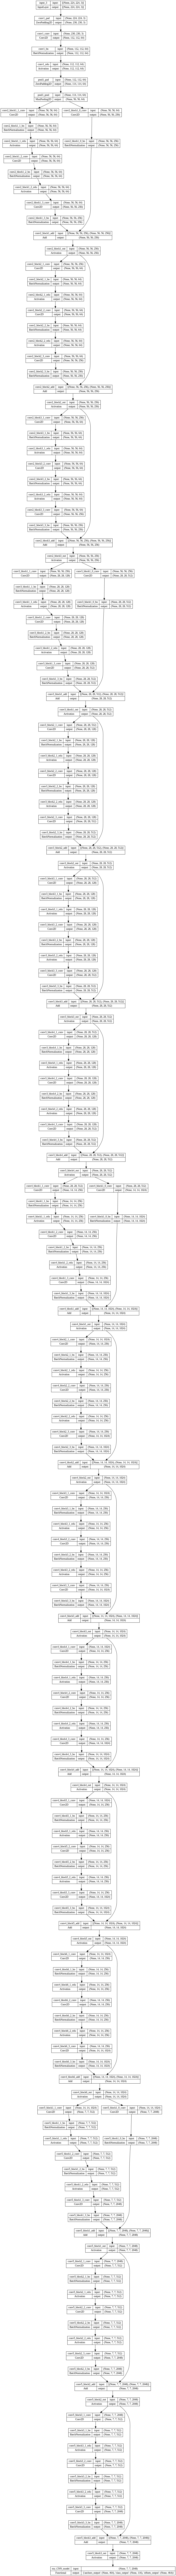

In [ ]:
# print(my_model.output)
# print(model.output)
# print(model.output[0].name)
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

In [ ]:
model_checkpoint_callback = ModelCheckpoint(filepath='weights.{epoch:02d}.h5', # Путь к файлу весов
                             save_weights_only=True, # Сохранять только веса модели
                             save_freq=2)

In [ ]:
epoch = 40 # we can set it to a large value because there is early stopping

# history = model.fit(x_train_img, [anchors, classification, offsets], batch_size = 6,
#                     epochs = epoch,
#                     validation_data = (x_val_img, [anchors_val, classification_val, offsets_val]),
#                     verbose = 1,
#                     #steps_per_epoch = x_train.shape[0] // 64,
#                     callbacks = model_checkpoint_callback)

history = model.fit(x_train_img, {"anchors_output": anchors,
                                  "class_output": classification,
                                  "offsets_output": offsets},
                    batch_size=6, epochs=epoch,
                    validation_data=(x_val_img, {"anchors_output": anchors_val,
                                                 "class_output": classification_val,
                                                 "offsets_output": offsets_val}),
                    verbose=1,
                    callbacks=model_checkpoint_callback)


Epoch 1/40
107/107 [==============================] - 136s 1s/step - loss: 0.1892 - my_CNN_model_loss: 2.2081e-08 - my_CNN_model_1_loss: 0.1804 - my_CNN_model_2_loss: 0.0076 - my_CNN_model_mean_absolute_error: 4.9970e-06 - my_CNN_model_1_accuracy: 0.0344 - my_CNN_model_2_mean_absolute_error: 0.0615 - val_loss: 0.3807 - val_my_CNN_model_loss: 1.3424e-13 - val_my_CNN_model_1_loss: 0.3598 - val_my_CNN_model_2_loss: 0.0196 - val_my_CNN_model_mean_absolute_error: 2.6598e-07 - val_my_CNN_model_1_accuracy: 0.0442 - val_my_CNN_model_2_mean_absolute_error: 0.1008
Epoch 2/40
107/107 [==============================] - 125s 1s/step - loss: 0.1929 - my_CNN_model_loss: 1.3424e-13 - my_CNN_model_1_loss: 0.1840 - my_CNN_model_2_loss: 0.0076 - my_CNN_model_mean_absolute_error: 2.6598e-07 - my_CNN_model_1_accuracy: 0.0328 - my_CNN_model_2_mean_absolute_error: 0.0617 - val_loss: 0.3760 - val_my_CNN_model_loss: 1.3424e-13 - val_my_CNN_model_1_loss: 0.3553 - val_my_CNN_model_2_loss: 0.0194 - val_my_CNN_mod

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(7contcontcont)1outfreezed.keras')

In [ ]:
#model = load_model('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(3contcontcont).keras')
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(7contcontcont)1outfreezed.keras')

In [ ]:
arr = ['anchor_layer_1', 'anchor_layer_2', 'FC_anchor_layer_1', 'FC_anchor_layer_2', 'FC_anchor_layer_3', 'anchors_output']
layer_name = model.get_layer('my_CNN_model')
for layer in layer_name.layers:
    if layer.name in arr:
        layer.trainable = False
        print('1')
    else: layer.trainable = True
    #print(layer.name)

1
1
1
1
1
1


In [ ]:
model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(7)lastWeight.h5')

ValueError: axes don't match array

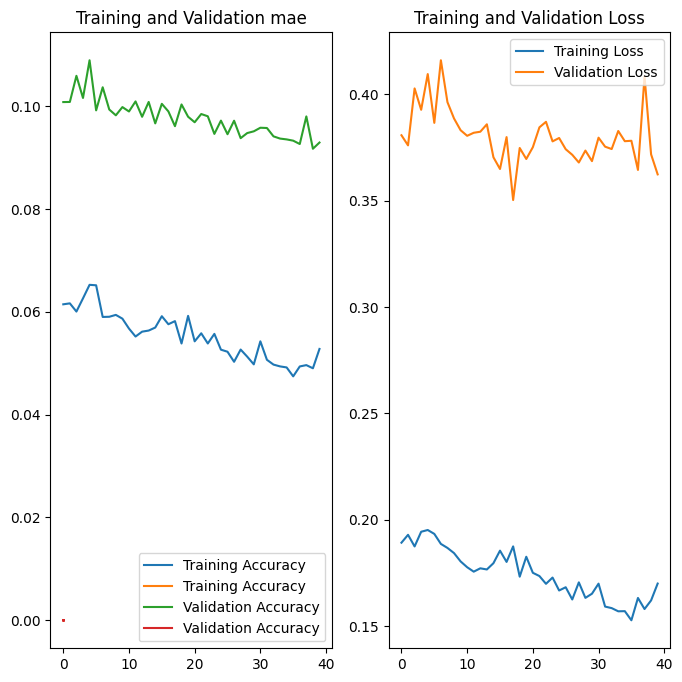

In [ ]:
acc = history.history['my_CNN_model_mean_absolute_error']
val_acc = history.history['val_my_CNN_model_mean_absolute_error']
acc1 = history.history['my_CNN_model_1_accuracy']
val_acc1 = history.history['val_my_CNN_model_1_accuracy']
acc2 = history.history['my_CNN_model_2_mean_absolute_error']
val_acc2 = history.history['val_my_CNN_model_2_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, acc1, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, val_acc1, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation mae')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("3_Training and Validation Accuracy and Loss.png", dpi=150)
plt.show()

In [ ]:
#МЕСТО ДЛЯ ТЕСТА CNN НА ИЗОБРАЖЕНИЯХ
width = 224
height = 224

# path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/riscvvv.jpg'
path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBZ6fKT-tY.jpg'
#path_to_object_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBdddZ6fKT-tY.jpg'
# path_to_full_img = 'fruits.jpg'


full_img = cv2.imread(path_to_full_img)
full_img = cv2.resize(full_img, (width, height))

full_img = full_img / 255.0


# object_img = cv2.imread(path_to_object_img)
# object_img = cv2.resize(object_img, (152, 152))

# old_image_height, old_image_width, channels = object_img.shape
# color = (255,255,255)
# result = np.full((height,width, channels), color, dtype=np.uint8)
# x_center = (width - old_image_width) // 2
# y_center = (height - old_image_height) // 2
# result[y_center:y_center+old_image_height,
#     x_center:x_center+old_image_width] = object_img

# object_img = result
#object_img = object_img / 255.0

full_img = np.expand_dims(full_img, axis=0)
#object_img = np.expand_dims(object_img, axis=0)

#print(full_img.shape, '\n', object_img.shape)

#overall_img = np.concatenate((full_img, object_img), axis=2)
#overall_img = np.expand_dims(overall_img, axis=0)

#model = load_model('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(2cont).keras')
#model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/RPN/RPN(2contcont)_24w.h5')

predictions = model.predict(full_img)
#print(predictions['offsets_output'])
print(len(predictions['anchors_output'][0]))
print(len(predictions['offsets_output'][0]))

# bb = np.array([124.0, 94.0, 180.0, 192.0])
# bb = np.expand_dims(bb, axis=0)

# cc = np.array([0.0])
# res = model.evaluate([full_img, object_img], [bb, cc])
# print(res)

1/1 [==============================] - 3s 3s/step
464
464


In [ ]:
print(anchors[0])

[  0.           0.          64.          64.           0.
  32.          64.          96.           9.372583    18.745166
  54.627417   109.254834     0.          64.          64.
 128.           9.372583    50.745166    54.627417   141.254834
   0.          96.          64.         160.           9.372583
  82.745166    54.627417   173.254834     0.         128.
  64.         192.           9.372583   114.745166    54.627417
 205.254834     0.         160.          64.         224.
  32.           0.          96.          64.          18.745166
   9.372583   109.254834    54.627417    32.          32.
  96.          96.          18.745166    41.372583   109.254834
  86.627417    41.372583    18.745166    86.627417   109.254834
   0.           0.         128.         128.          32.
  64.          96.         128.          18.745166    73.372583
 109.254834   118.627417    41.372583    50.745166    86.627417
 141.254834     0.          32.         128.         160.
  18.745166     5.

In [ ]:
#print(predictions['anchors_output'][0])
pred = predictions['anchors_output'][0]
for i in range(len(predictions['anchors_output'][0])):
    pred[i] = predictions['anchors_output'][0][i] * 224
    print(pred[i])

-2.002716e-05
-3.119465e-06
64.00002
64.00001
0.00020787958
32.000027
63.99995
95.999954
9.372522
18.745049
54.627403
109.25489
0.00013893843
64.00008
64.00015
128.00008
9.372187
50.745193
54.62745
141.25487
4.5895576e-06
96.00008
64.0
160.00005
9.372511
82.744995
54.62731
173.25479
1.3299286e-05
128.00002
63.999836
191.99994
9.372635
114.74513
54.62744
205.25479
0.00011275709
160.00003
63.999935
224.00006
31.999825
-0.00011703372
96.00007
63.999943
18.745201
9.372568
109.25481
54.627403
32.000153
31.999838
96.00001
95.99999
18.74506
41.372562
109.254906
86.627426
41.37258
18.745195
86.62737
109.25484
-2.8502604e-05
7.082522e-05
128.00012
127.99998
31.999968
63.999996
96.00003
127.99978
18.745169
73.37256
109.254875
118.627365
41.372528
50.745113
86.62732
141.25476
-2.7380884e-05
32.000053
127.999954
159.99988
18.74518
5.490191
109.25491
186.50958
31.999992
95.99993
95.999985
160.00002
18.745161
105.372536
109.25487
150.62732
41.372574
82.74519
86.62749
173.25484
3.7550926e-05
63.99997

In [ ]:
print(len(av[0]))
print(av[1])
print(anchors[0][460:])
print(predictions['offsets_output'][0][460:])
# print(av[0][2])
# print(av[0][3])

3
[144.77269744873047, -12.39539909362793, 112.32923126220703, 78.57850170135498]
[160. 160. 224. 224.]
[-94.548134 -41.94802  -59.71702  -57.107433]


In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
h = []
id = 1
for i in range(len(a)):
    if id % 4 == 0 and id != 0:
        h.append(a[i] + b[i])
    id += 1

print(h)

[8, 16, 24]


# **ПРОВЕРКА ДАННЫХ НА ФОТКЕ**

In [ ]:
print(len(anchors[0]))

464


[0.0, 0.0, 0.1566265060240964, 0.0, 0.0, 0.0]
0.1566265060240964
[  9.372583  50.745166  54.627417 141.254834]
[ 16.254834 -28.254834  17.627417  21.372583]


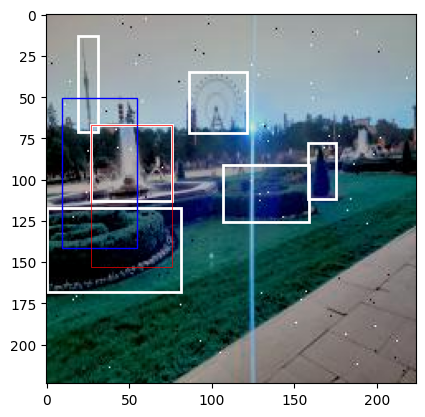

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print(iou_storage[0][:6])
print(classification[0][0])
print(anchors[0][16:20])
print(offsets[0][16:20])

path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/RPN/train/IMG20230910182523_jpg.rf.fea510241bdefc7cd956697325e2872e.jpg'
object_img = cv2.imread(path_to_full_img)
object_img = cv2.resize(object_img, (224, 224))
fig, ax = plt.subplots()
ax.imshow(object_img)

for i in range(len(y_train[0])):
    #for j in range(len(y_train[0][i])):
    #print(y_train[0][i][0], y_train[0][i][1], y_train[0][i][2], y_train[0][i][3])
    rect1 = patches.Rectangle((y_train[0][i][0], y_train[0][i][1]), y_train[0][i][2] - y_train[0][i][0], y_train[0][i][3] - y_train[0][i][1], linewidth=2, edgecolor='w', facecolor='none')
    ax.add_patch(rect1)

# rect1 = patches.Rectangle((y_train[0][0][0], y_train[0][0][1]), y_train[0][0][2] - y_train[0][0][0], y_train[0][0][3] - y_train[0][0][1], linewidth=2, edgecolor='w', facecolor='none')
# ax.add_patch(rect1)

# print(y_train[0][0][0], y_train[0][0][1])
# print(y_train[0][0][2] - y_train[0][0][0])
# print(y_train[0][0][3] - y_train[0][0][0])

rect = patches.Rectangle((anchors[0][16], anchors[0][17]), anchors[0][18] - anchors[0][16], anchors[0][19] - anchors[i][17], linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((anchors[0][16]+offsets[0][18], anchors[0][17]+offsets[0][16]), (anchors[0][18]+offsets[0][19]) - (anchors[0][16]+offsets[0][18]), (anchors[0][19]+offsets[0][17]) - (anchors[0][16]+offsets[0][18]), linewidth=0.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# rect = patches.Rectangle((anchors[0][0]-offsets[0][0], anchors[0][1]-offsets[0][1]), (anchors[0][2]-offsets[0][2]) - (anchors[0][0]-offsets[0][0]), (anchors[0][3]-offsets[0][3]) - (anchors[0][0]-offsets[0][0]), linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

plt.show()

In [ ]:
def contraction_to_center(coord):
    x1, y1, x2, y2 = coord

    # Вычисление координат центра прямоугольника
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Вычисление сжатых координат прямоугольника
    x1_new = center_x - (center_x - x1) // 2
    y1_new = center_y - (center_y - y1) // 2
    x2_new = center_x + (x2 - center_x) // 2
    y2_new = center_y + (y2 - center_y) // 2

    coord_ = []
    coord_.append(x1_new)
    coord_.append(y1_new)
    coord_.append(x2_new)
    coord_.append(y2_new)

    return coord_

In [ ]:
def contraction_to_angles(coord, id):#по часовой с верхнего левого угла
    width = 224
    height = 224

    x1, y1, x2, y2 = coord

    if x1 < 0: x1 = 0
    if y1 < 0: y1 = 0
    if x2 > width: x2 = width
    if y2 > height: y2 = height

    width = x2 - x1
    height = y2 - y1

    if id == 0:
        x2 = x2 - width / 2
        y2 = y2 - height / 2
    elif id == 1:
        x1 = x1 + width / 2
        y2 = y2 - height / 2
    elif id == 2:
        x1 = x1 + width / 2
        y1 = y1 + height / 2
    elif id == 3:
        y1 = y1 + height / 2
        x2 = x2 - width / 2
    else: print('неверный id')

    coord_ = []
    coord_.append(x1)
    coord_.append(y1)
    coord_.append(x2)
    coord_.append(y2)

    return coord_

In [ ]:
def contraction_to_sides(coord, id):#по часовой с верху
    width1 = 224
    height1 = 224

    x1, y1, x2, y2 = coord

    if x1 < 0: x1 = 0
    if y1 < 0: y1 = 0
    if x2 > width1: x2 = width1
    if y2 > height1: y2 = height1

    width = x2 - x1
    height = y2 - y1

    if id == 0:
        x1 = x1 + width / 4
        x2 = x2 - width / 4
        y2 = y2 - height / 2
    elif id == 1:
        x1 = x1 + width / 2
        y1 = y1 + height / 4
        y2 = y2 - height / 4
    elif id == 2:
        x1 = x1 + width / 4
        y1 = y1 + height / 2
        x2 = x2 - width / 4
    elif id == 3:
        y1 = y1 + height / 4
        x2 = x2 - width / 2
        y2 = y2 - height / 4
    else: print('неверный id')

    coord_ = [x1, y1, x2, y2]

    return coord_

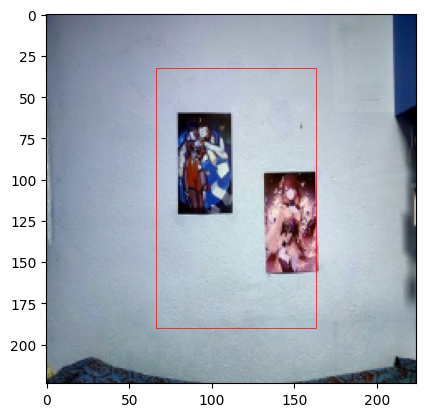

In [ ]:
#ЕСЛИ КООРДИНАТЫ +-5 ПОВТОРЯЮТСЯ ИХ МОЖНО СЖАТЬ:
#К ЦЕНТРУ, В ЛЕВО, В ПРАВО, В ВЕРХ, В НИЗ, К УГЛАМ. ИТОГО ИЗ 1 РАМКИ - 9 РАМОК
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/RPN/train/IMG20230910182523_jpg.rf.fea510241bdefc7cd956697325e2872e.jpg'
path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBZ6fKT-tY.jpg'
# path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/riscvvv.jpg'
# path_to_full_img = 'fruits.jpg'

object_img = cv2.imread(path_to_full_img)
object_img = cv2.resize(object_img, (224, 224))

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(object_img)
#av = [[86,35,121,72], [158,78,175,112], [19,13,31,71], [0,117,81,168], [107,91,159,126], [27,67,76,113]]
av = []

id = 1
b = []
count = 0
in0 = 0
in1 = 1
in2 = 2
in3 = 3
for i in range(len(anchors[0])):#464
    if count == 0: value = anchors[0][in1] * 224 + predictions['offsets_output'][0][i] * 224
    elif count == 1: value = anchors[0][in3] * 224 + predictions['offsets_output'][0][i] * 224
    elif count == 2: value = anchors[0][in0] * 224 + predictions['offsets_output'][0][i] * 224
    elif count == 3: value = anchors[0][in2] * 224 + predictions['offsets_output'][0][i] * 224

    # if count == 0: value = anchors[0][in1] + predictions['offsets_output'][0][i]
    # elif count == 1: value = anchors[0][in3] + predictions['offsets_output'][0][i]
    # elif count == 2: value = anchors[0][in0] + predictions['offsets_output'][0][i]
    # elif count == 3: value = anchors[0][in2] + predictions['offsets_output'][0][i]


    b.append(value)
    count += 1
    if id % 4 == 0 and id != 0:

        y1, y2, x1, x2 = b

        b[0] = x1
        b[1] = y1
        b[2] = x2
        b[3] = y2

        av.append(b)

        # bb = contraction_to_sides(b, 1)
        # av.append(bb)#--------------------------------------------experimental

        b = []
        count = 0
        in0 += 4
        in1 += 4
        in2 += 4
        in3 += 4
    # if id == len(anchors[0]) - 1:
    #     av.append(b)
    #     b = []

    id += 1
# Create a Rectangle patch
# for i in range(len(av)):
#     for j in range(len(av[0])):
#         rect = patches.Rectangle((av[i][0], av[i][1]), av[i][2] - av[i][0], av[i][3] - av[i][1], linewidth=0.5, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#50.745166   9.372583 141.254834  54.627417
#print(anchors[15])
i = 13
# print(av[i])
# print(predictions['class_output'][0][i])
# rect = patches.Rectangle((anchors[i][0], anchors[i][1]), anchors[i][2] - anchors[i][0], anchors[i][3] - anchors[i][1], linewidth=0.5, edgecolor='b', facecolor='none')
# ax.add_patch(rect)
# Добавление прямоугольника на график
rect = patches.Rectangle((av[i][0], av[i][1]), av[i][2] - av[i][0], av[i][3] - av[i][1], linewidth=0.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# ii = (i + 1) * 4
# jj = ii - 4
# Отображение графика
plt.show()
#print(offsets[0][jj:ii])

In [ ]:
#каждый из myset_to_use и remain_anchors пройдет разделение на прямоугольники
matching_rectangles = []

for i, rect1 in enumerate(av):
    count = 1
    for j, rect2 in enumerate(av[i+1:]):
        is_match = True
        for k in range(4):
            if abs(rect1[k] - rect2[k]) > 10:
                is_match = False
                break
        if is_match:
            count += 1
            matching_rectangles.append(i)
            matching_rectangles.append(i+j+1)

    # if count > 1:
    #     print(f"Прямоугольник с ID {i} имеет {count} совпадений.")

#print("Список совпадающих прямоугольников:")
one = []
two = []
for i in range(0, len(matching_rectangles), 2):
    #print(f"{matching_rectangles[i]} и {matching_rectangles[i+1]}")
    one.append(matching_rectangles[i])
    two.append(matching_rectangles[i+1])

myset_to_use = set(one)
myset_not_to_use = set(two)
print(myset_to_use)
print(myset_not_to_use)

{10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 106, 107}
{11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 109}


In [ ]:
all_from_sets = set.union(myset_to_use, myset_not_to_use)
all_anchors_id = set(range(116))
remain_anchors = all_anchors_id.difference(all_from_sets)
print(all_from_sets)
print(all_anchors_id)
print(remain_anchors)

{10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 108, 110, 111, 112, 113, 114, 115, 30}


In [ ]:
new_av = []
remain_anchors = list(remain_anchors)
myset_to_use = list(myset_to_use)
#myset_not_to_use = list(myset_not_to_use)

for i in remain_anchors:
    new_av.append(av[i])

for j in myset_to_use:
    one = contraction_to_center(av[j])
    new_av.append(one)

    for k in range(4):
        two = contraction_to_angles(av[j], k)
        three = contraction_to_sides(av[j], k)
        new_av.append(two)
        new_av.append(three)

new_av = np.array(new_av)
print(new_av.shape)#количество новых анкерных ящиков

(846, 4)


In [ ]:
print(new_av[356])

[ 34.79891318 147.89883706  91.22885129 187.88990101]


In [ ]:
print(predictions['offsets_output'][0][456:460])
#print(predictions['offsets_output'][0][35] * 224)
print(anchors[0][456:460])

[-19.781286 -33.23217  -38.527115  -8.162306]
[169.372583 114.745166 214.627417 205.254834]


# **Генераторы данных**

In [ ]:
import os
class dataset():
    def __init__(self, data_folder, transform):
        self.image_list = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, i):
        #TODO: получить индекс картинки
        # скачать картинку
        # применить трансформации
        # вернуть тройку: картинку, аугментацию и y_target
        return self.image_list[i]

In [ ]:
d = dataset(data_folder='sample_data')

In [ ]:
d[0]

'anscombe.json'

In [ ]:
def load_and_preprocess_image(image_path, image_size):
    # Загрузка изображения и предобработка, включая изменение размера и нормализацию
    # Здесь вам нужно написать соответствующий код для загрузки и предобработки изображений с использованием Pillow, OpenCV или других библиотек.
    #print(image_path)
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = np.array(img)

    augmentations = [datagen__, datagen_, datagen, 'none']
    selected_augmentation = random.choice(augmentations)
    if selected_augmentation != 'none':
        augmented_image = selected_augmentation.random_transform(img)
        preprocessed_image = augmented_image
    else: preprocessed_image = img

    preprocessed_image = preprocessed_image.astype(np.float64)
    preprocessed_image /= 255.0
    return preprocessed_image

In [ ]:
count = 0
class SiameseImageGenerator:
    def __init__(self, image_paths, batch_size=32, image_size=(224, 224)):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.indices = np.arange(len(self.image_paths))
        self.num_samples = 6016

    # def __getitem__(self, index):
    #     start = index * self.batch_size
    #     end = min((index + 1) * self.batch_size, self.num_samples)

    #     data_batch = []
    #     for i in range(start, end):
    #         data = self.data_files[i]
    #         # загрузка данных из файла и преобразование
    #         # добавление данных в data_batch
    #     return np.array(data_batch)

    def generate(self, index):
        global count
        # while True:
        pairs = [[], []]
        targets = []
        for i in range(self.batch_size):
            num = (5 - len(str(index))) * '0'
            num += str(index)
            #print(count)

            np.random.shuffle(self.indices)

            random_number = int(num)
            while random_number == int(num):
                random_number = random.randint(0, 6015)

            num_ = (5 - len(str(random_number))) * '0'
            num_ += str(random_number)
            #random_number = (5 - len(str(random_number))) * '0'
            #random_number += str(random_number)

            self.image_paths[0] = self.image_paths[0][:53]
            self.image_paths[1] = self.image_paths[1][:54]
            self.image_paths[0] = image_paths[0] + num + '.jpg'
            self.image_paths[1] = image_paths[1] + num_ + '.jpg'
            #print(self.image_paths[0], self.image_paths[1])

            # for idx in self.indices:#0,1
            #     image_path = self.image_paths[idx]
                #print(image_path, 'tutb')
                #img = load_and_preprocess_image(image_path, self.image_size) # Функция загрузки и предобработки изображения
            img = cv2.imread(self.image_paths[0])
            img = cv2.resize(img, self.image_size)
            img = np.array(img)
            pairs[0].append(img)

            num_check = np.random.rand()
            if num_check < 0.5: # Случайным образом решаем, будут ли изображения подобными или различными
                # positive_idx = idx
                # while positive_idx == idx:
                #     positive_idx = np.random.choice(np.where(self.indices != idx)[0], 1)[0]
                pairs[1].append(load_and_preprocess_image(self.image_paths[0], self.image_size))
                targets.append(1)
            else:
                # negative_idx = np.random.choice(len(self.image_paths), 1)[0]
                # while negative_idx == idx:
                #     negative_idx = np.random.choice(len(self.image_paths), 1)[0]
                pairs[1].append(load_and_preprocess_image(self.image_paths[1], self.image_size))
                targets.append(0)

            #print(np.array(pairs[0]).shape, np.array(pairs[1]).shape, np.array(targets).shape)
            if len(targets) == self.batch_size:
                yield [np.array(pairs[0]), np.array(pairs[1])], np.array(targets)
                #return [np.array(pairs[0]), np.array(pairs[1])], np.array(targets)
                pairs = [[], []]
                targets = []
            count += 1
            #if count == 63: break

In [ ]:
path1 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left/"
path2 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/right/"
#print(len(path1), len(path2))
image_paths = [path1, path2] # Список путей к изображениям
siamese_generator = SiameseImageGenerator(image_paths)

#gen = siamese_generator.generate()

# # Получение данных из генератора и вывод первого батча данных
# for batch_data, batch_targets in gen:
#     print(batch_data[0].shape)  # Форма первого изображения
#     print(batch_data[1].shape)  # Форма второго изображения
#     print(batch_targets.shape)  # Форма меток

# print(batch_data[0].shape)  # Форма первого изображения
# print(batch_data[1].shape)  # Форма второго изображения
# print(batch_targets.shape)
# try:
#     # Пример выведения первого батча данных
#     batch_data, batch_targets = next(gen)
#     print(batch_data[0].shape)  # Форма первого изображения
#     print(batch_data[1].shape)  # Форма второго изображения
#     print(batch_targets.shape)  # Форма меток
# except StopIteration:
#     print("Данные в генераторе закончились.")


# images, targets = next(gen)

In [ ]:
for epoch in range(188):
    for batch_data, batch_targets in siamese_generator.generate(epoch):
        batch_a = batch_data[0]  # первая половина пакета
        batch_b = batch_data[1]  # вторая половина пакета
        labels = batch_targets  # задайте соответствующие метки для пакета

        ss = siamese_model.train_on_batch([batch_a, batch_b], labels)

        # Отображение потерь и метрик для каждой эпохи
        print(ss)


[0.7202825546264648, 0.3125]
[0.7281296253204346, 0.375]
[0.7511259317398071, 0.375]
[0.6933806538581848, 0.5]
[0.6911188364028931, 0.53125]
[0.6773086786270142, 0.59375]
[0.6987184286117554, 0.53125]
[0.7309019565582275, 0.4375]
[0.6994950771331787, 0.4375]
[0.6884541511535645, 0.65625]
[0.6947263479232788, 0.40625]
[0.6919124722480774, 0.59375]
[0.6876162886619568, 0.71875]
[0.6915544271469116, 0.53125]
[0.7160376906394958, 0.4375]
[0.7140045166015625, 0.46875]
[0.6938332319259644, 0.40625]
[0.6932345628738403, 0.5]
[0.67643803358078, 0.6875]
[0.70728600025177, 0.46875]
[0.7179352045059204, 0.40625]
[0.6985915899276733, 0.34375]
[0.7037899494171143, 0.4375]
[0.7008618712425232, 0.4375]
[0.7183520793914795, 0.34375]
[0.6989696025848389, 0.4375]
[0.693169891834259, 0.5]
[0.6967575550079346, 0.375]
[0.696467399597168, 0.34375]
[0.692870020866394, 0.53125]
[0.6921741962432861, 0.65625]
[0.6934196949005127, 0.4375]
[0.6940639615058899, 0.34375]
[0.6931450963020325, 0.5]
[0.695350885391235

1


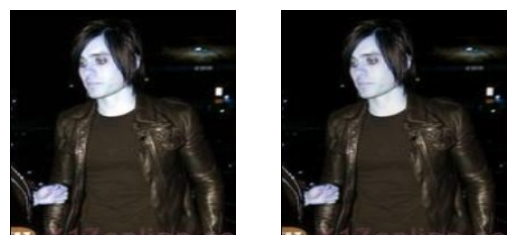

In [ ]:
i = 11

print(batch_targets[i])
plt.subplot(121)
plt.imshow(batch_data[0][i].astype('uint8'), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(batch_data[1][i].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#ФОРМИРОВАНИЕ X_TRAIN
folder_dir = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left"

x_train_img_1 = []
x_train_img_2 = []

count = 0
count_img = 0
count_for_stop = 0
for image in os.listdir(folder_dir):
    if count_for_stop > 1008:
        if image.endswith(".jpg"):

            img1 = cv2.imread(folder_dir + "/" + image)
            # img1 = cv2.resize(img1, (64, 64))
            img1 = cv2.resize(img1, (224, 224))
            img1 = np.array(img1)

            if count != 3:
                x_train_img_1.append(img1)#одно и то же
                x_train_img_2.append(img1)
                #print('ob - ob')
                count += 1
                count_img += 1
                cc = 0
                image11 = np.expand_dims(img1, axis=0)
                for batch in datagen.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                    #print(count_img)
                    if count_img == 12: count = 3
                    if count == 3 and count_img > 11:
                        img2 = x_train_img_1[count_img - 12]
                        count = 0

                        augmentations = [datagen__, datagen_, datagen, 'none']
                        selected_augmentation = random.choice(augmentations)
                        if selected_augmentation != 'none':
                            augmented_image = selected_augmentation.random_transform(img2)
                            x_train_img_2.append(augmented_image)
                        else: x_train_img_2.append(img2)

                        x_train_img_1.append(img1)#разные (но должны быть и ауг)

                        #print('ob - 1au--')
                        count += 1
                        count_img += 1
                    else:
                        x_train_img_1.append(img1)
                        x_train_img_2.append(batch[0])
                        #print('ob - 1au')
                        count += 1
                        count_img += 1
                        if cc >= 3:  # Генерируем 6 аугментированных изображений
                            cc = 0
                            break
                        cc += 1


                for batch in datagen_.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                    #print(count_img)
                    if count_img == 12: count = 3
                    if count == 3 and count_img > 11:
                        img2 = x_train_img_1[count_img - 12]
                        count = 0

                        augmentations = [datagen__, datagen_, datagen, 'none']
                        selected_augmentation = random.choice(augmentations)
                        if selected_augmentation != 'none':
                            augmented_image = selected_augmentation.random_transform(img2)
                            x_train_img_2.append(augmented_image)
                        else: x_train_img_2.append(img2)

                        x_train_img_1.append(img1)
                        #print('ob - 1au--')
                        count += 1
                        count_img += 1
                    else:
                        x_train_img_1.append(img1)
                        x_train_img_2.append(batch[0])
                        #print('ob - 1au')
                        count += 1
                        count_img += 1
                        if cc >= 1:  # Генерируем 6 аугментированных изображений
                            cc = 0
                            break
                        cc += 1


                for batch in datagen__.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                    #print(count_img)
                    if count_img == 12: count = 3
                    if count == 3 and count_img > 11:
                        img2 = x_train_img_1[count_img - 12]
                        count = 0

                        augmentations = [datagen__, datagen_, datagen, 'none']
                        selected_augmentation = random.choice(augmentations)
                        if selected_augmentation != 'none':
                            augmented_image = selected_augmentation.random_transform(img2)
                            x_train_img_2.append(augmented_image)
                        else: x_train_img_2.append(img2)

                        x_train_img_1.append(img1)
                        #print('ob - 1au--')
                        count += 1
                        count_img += 1
                    else:
                        x_train_img_1.append(img1)
                        x_train_img_2.append(batch[0])
                        #print('ob - 1au')
                        count += 1
                        count_img += 1
                        if cc >= 1:  # Генерируем 6 аугментированных изображений
                            cc = 0
                            break
                        cc += 1


            if count_img == 12: count = 3
            if count == 3 and count_img > 11:
                img2 = x_train_img_1[count_img - 12]
                count = 0

                augmentations = [datagen__, datagen_, datagen, 'none']
                selected_augmentation = random.choice(augmentations)
                if selected_augmentation != 'none':
                    augmented_image = selected_augmentation.random_transform(img2)
                    x_train_img_2.append(augmented_image)
                else: x_train_img_2.append(img2)

                x_train_img_1.append(img1)
                #print('ob - 2au--')
                count_img += 1
                count += 1
            if count_img >= 2360: break
    else: count_for_stop += 1


# **Сиамская нейросеть**

**Подготовка данных**

In [ ]:
#без аугментации
#ФОРМИРОВАНИЕ X_TRAIN И Y_TRAIN
import random
folder_dir = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left"

x_train_img_1 = []
x_train_img_2 = []

y_train = []

for_shuffle = []

flag = 0
count_img = 0
passing = 0
for image in os.listdir(folder_dir):
    if passing > 2500:
        if image.endswith(".jpg"):

            img = cv2.imread(folder_dir + "/" + image)
            img = cv2.resize(img, (224, 224))
            img = np.array(img)

            x_train_img_1.append(img)
            count_img += 1

            if flag:
                for_shuffle.append(img)
                flag = 0
            else:
                flag = 1
        if count_img >= 2512: break
    else: passing += 1

random.shuffle(for_shuffle)

flag = 0
id = 0
count_img = 0
passing = 0
for image in os.listdir(folder_dir):
    if passing > 2500:
        if image.endswith(".jpg"):

            img = cv2.imread(folder_dir + "/" + image)
            img = cv2.resize(img, (224, 224))
            img = np.array(img)

            if flag:
                x_train_img_2.append(for_shuffle[id])
                y_train.append(0)
                flag = 0
                id += 1
            else:
                x_train_img_2.append(img)
                y_train.append(1)
                flag = 1
            count_img += 1
        if count_img >= 2512: break
    else: passing += 1

y_train = np.array(y_train)

In [ ]:
#Данные с left и right
# folder_dir_1 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left"
# folder_dir_2 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/right"

x_train_img_1 = []
x_train_img_2 = []
y_train = []


for i in range(6016):
    if i % 100 == 0: print(i)
    num = (5 - len(str(i))) * '0'
    # for j in range(5 - len(str(i))): num += '0'
    num += str(i)

    path_1 = f"/content/gdrive/MyDrive/Colab Notebooks/Siamese/left/{num}.jpg"
    path_2 = f"/content/gdrive/MyDrive/Colab Notebooks/Siamese/right/{num}.jpg"

    img = cv2.imread(path_1)
    img = cv2.resize(img, (64, 64))
    img = np.array(img)
    x_train_img_1.append(img)

    img = cv2.imread(path_2)
    img = cv2.resize(img, (64, 64))
    img = np.array(img)
    x_train_img_2.append(img)

    y_train.append(1)

# for image_1 in os.listdir(folder_dir_1):
#     compare = int(image_1[:5])
#     for image_2 in os.listdir(folder_dir_2):

        # if image_1.endswith(".jpg") and image_2.endswith(".jpg"):
        #     if compare == int(image_2[:5]):
        #         img = cv2.imread(folder_dir_1 + "/" + image_1)
        #         img = cv2.resize(img, (64, 64))
        #         img = np.array(img)
        #         x_train_img_1.append(img)

        #         img = cv2.imread(folder_dir_2 + "/" + image_2)
        #         img = cv2.resize(img, (64, 64))
        #         img = np.array(img)
        #         x_train_img_2.append(img)

        #         y_train.append(1)
        #         break

y_train = np.array(y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100


KeyboardInterrupt: 

In [ ]:
#customize function used for color convetion
def to_grey(image):
    image = np.array(image)

    for i in range(len(image)):
        for j in range(len(image[i])):
            k_first = image[i][j][0]
            for k in range(len(image[i][j])):
                image[i][j][k] = k_first

    #converted_img /= 255
    return image

In [ ]:
# Создаем объект ImageDataGenerator для аугментации изображений
import random

def multiple_preprocessing_function(image):
    # Apply multiple preprocessing functions from the original list
    arr = [None, 'to_grey']
    random_number = random.randint(0, 1)

    if random_number == 1:
        image = to_grey(image)
    return image

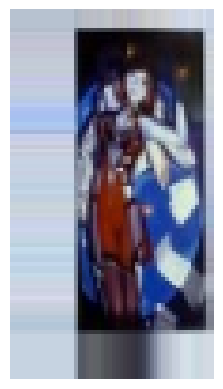

In [ ]:
# import random
# image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/rPBdddZ6fKT-tY.jpg')

# # Создайте список с вашими объектами ImageDataGenerator
# augmentations = [datagen__, datagen_, datagen]

# # Выберите случайную аугментацию
# selected_augmentation = random.choice(augmentations)

# # Применить аугментацию к изображению
# augmented_image1 = selected_augmentation.random_transform(image)


# plt.imshow(augmented_image1, cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:
datagen__ = ImageDataGenerator(brightness_range=(0.8, 1.2),
                               fill_mode='nearest')
datagen_ = ImageDataGenerator(zoom_range=[1.1, 1.3],
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              preprocessing_function=multiple_preprocessing_function,
                              fill_mode='nearest')
datagen = ImageDataGenerator(
    #rotation_range=10,  # Вращение на 10 градусов
    width_shift_range=0.1,  # Сдвиг по горизонтали на 10% ширины
    height_shift_range=0.1,  # Сдвиг по вертикали на 10% высоты
    #shear_range=0.1,  # Искажение изображения по горизонтали
    #brightness_range=(0.5, 1.5),
    #channel_shift_range=0.6,
    preprocessing_function=multiple_preprocessing_function,
    #zoom_range=[1.1, 2],  # Увеличение или уменьшение масштаба на 20%
    # horizontal_flip=True,  # Отражение изображения по горизонтали
    fill_mode='nearest'  # Режим заполнения пикселей после преобразований
)

# Загружаем изображение
# image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/rPBdddZ6fKT-tY.jpg')

# # Создаем форму для изображения (добавляем размерность пакета данных, если требуется)
# image = cv2.resize(image, (224, 224))
# image = image.reshape((1,) + image.shape)

# # Генерируем аугментированное изображение
# augmented_images = []
# for batch in datagen.flow(image, batch_size=1):  # Создаем поток аугментированных изображений
#     augmented_images.append(batch)
#     if len(augmented_images) >= 4:  # Генерируем 5 аугментированных изображений
#         break

# for batch in datagen_.flow(image, batch_size=1):  # Создаем поток аугментированных изображений
#     augmented_images.append(batch)
#     if len(augmented_images) >= 5:  # Генерируем 5 аугментированных изображений
#         break

# for batch in datagen__.flow(image, batch_size=1):  # Создаем поток аугментированных изображений
#     augmented_images.append(batch)
#     if len(augmented_images) >= 5:  # Генерируем 5 аугментированных изображений
#         break

# # Визуализируем аугментированные изображения
# for i, augmented_image in enumerate(augmented_images):
#     plt.subplot(2, 3, i+1)
#     plt.imshow(augmented_image[0].astype('uint8'), cmap='gray')
#     plt.axis('off')
# plt.show()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


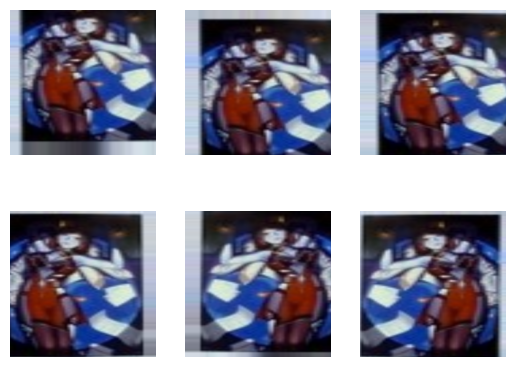

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/rPBdddZ6fKT-tY.jpg')
image = cv2.resize(image, (224, 224))
image = np.array(image)

image = np.expand_dims(image, axis=0)

augmented_images = []
for batch in datagen.flow(image, batch_size=1):  # Создаем поток аугментированных изображений
    augmented_images.append(batch)
    if len(augmented_images) >= 6:  # Генерируем 5 аугментированных изображений
        break

    print(batch[0].shape)

for i in range(len(augmented_images)):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i][0].astype('uint8'), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
from pathlib import Path
cache_dir = Path(Path.home()) / ".keras"
#anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right/right"
#!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
#!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

"gdown" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
import zipfile
with zipfile.ZipFile('left.zip', 'r') as zip_ref:
    zip_ref.extractall('left/')

In [ ]:
# import multiprocessing
# from queue import Queue

# def read_images(start, end, queue):
#     #images = []
#     for i in range(start, end):
#         num = (5 - len(str(i))) * '0'
#         num += str(i)
#         img_path = f"left/left/{num}.jpg"
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, (224, 224))
#         #images.append(img)
#         queue.put(img)

#     #return images

# if __name__ == "__main__":
#     num_images = 6016
#     num_threads = 16
#     images_per_thread = num_images // num_threads
#     queue = Queue()
#     processes = []
#     for i in range(num_threads):
#         start = i * images_per_thread
#         end = start + images_per_thread if i < num_threads - 1 else num_images
#         p = multiprocessing.Process(target=read_images, args=(start, end, queue))
#         processes.append(p)
#         p.start()

#     for p in processes:
#         p.join()
#     arr = []
#     while not queue.empty():
#         img = queue.get()
#         arr.append(img)

In [ ]:
folder_dir = 'right/right'

x_train_img_1 = []
x_train_img_2 = []

count = 0
for image in os.listdir(folder_dir):
    if image.endswith(".jpg"):

        img1 = cv2.imread(folder_dir + "/" + image)
        img1 = cv2.resize(img1, (224, 224))
        img1 = np.array(img1)
        x_train_img_1.append(img1)

        if count % 2 == 0:
            random_number = count
            while random_number == count:
                random_number = random.randint(0, 6015)

            num = (5 - len(str(random_number))) * '0'
            num += str(random_number)
            img2 = cv2.imread(f'{folder_dir}/{num}.jpg')
            img2 = cv2.resize(img2, (224, 224))
            img2 = np.array(img2)
            x_train_img_2.append(img2)
        else:
            x_train_img_2.append(img1)

        count += 1

In [ ]:
y_train = []
print(len(x_train_img_1) == len(x_train_img_2))
for i in range(len(x_train_img_1)):
    if i % 2 == 0:
        y_train.append(0)
    else: y_train.append(1)
y_train = np.array(y_train)

True


In [ ]:
#ФОРМИРОВАНИЕ X_TRAIN
#folder_dir = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left"
folder_dir = "left/left"
# folder_dir = 'right/right'

x_train_img_1 = []
x_train_img_2 = []

count = 0
count_img = 0
count_for_stop = 0
for image in os.listdir(folder_dir):
    #if count_for_stop > 1008:
    if image.endswith(".jpg"):
        print(count_for_stop)
        count_for_stop += 1
        img1 = cv2.imread(folder_dir + "/" + image)
        # img1 = cv2.resize(img1, (64, 64))
        img1 = cv2.resize(img1, (224, 224))
        img1 = np.array(img1)

        if count != 3:
            x_train_img_1.append(img1)#одно и то же
            x_train_img_2.append(img1)
            #print('ob - ob')
            count += 1
            count_img += 1
            cc = 0
            image11 = np.expand_dims(img1, axis=0)
            for batch in datagen.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                #print(count_img)
                if count_img == 12: count = 3
                if count == 3 and count_img > 11:
                    # print(count_img, count_img - 12, ' -a')

                    random_number = count_for_stop
                    while random_number == count_for_stop:
                        random_number = random.randint(0, 6015)

                    num = (5 - len(str(random_number))) * '0'
                    num += str(random_number)
                    img2 = cv2.imread(f'{folder_dir}/{num}.jpg')
                    img2 = cv2.resize(img2, (224, 224))
                    img2 = np.array(img2)

                    # img2 = x_train_img_1[count_img - 12]
                    count = 0

                    augmentations = [datagen__, datagen_, datagen, 'none']
                    selected_augmentation = random.choice(augmentations)
                    if selected_augmentation != 'none':
                        augmented_image = selected_augmentation.random_transform(img2)
                        x_train_img_2.append(augmented_image)
                    else: x_train_img_2.append(img2)

                    x_train_img_1.append(img1)#разные (но должны быть и ауг)

                    #print('ob - 1au--')
                    count += 1
                    count_img += 1
                else:
                    x_train_img_1.append(img1)
                    x_train_img_2.append(batch[0])
                    #print('ob - 1au')
                    count += 1
                    count_img += 1
                    if cc >= 3:  # Генерируем 6 аугментированных изображений
                        cc = 0
                        break
                    cc += 1


            for batch in datagen_.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                #print(count_img)
                if count_img == 12: count = 3
                if count == 3 and count_img > 11:
                    # print(count_img, count_img - 12, ' -b')


                    random_number = count_for_stop
                    while random_number == count_for_stop:
                        random_number = random.randint(0, 6015)

                    num = (5 - len(str(random_number))) * '0'
                    num += str(random_number)
                    img2 = cv2.imread(f'{folder_dir}/{num}.jpg')
                    img2 = cv2.resize(img2, (224, 224))
                    img2 = np.array(img2)
                    # img2 = x_train_img_1[count_img - 12]
                    count = 0

                    augmentations = [datagen__, datagen_, datagen, 'none']
                    selected_augmentation = random.choice(augmentations)
                    if selected_augmentation != 'none':
                        augmented_image = selected_augmentation.random_transform(img2)
                        x_train_img_2.append(augmented_image)
                    else: x_train_img_2.append(img2)

                    x_train_img_1.append(img1)
                    #print('ob - 1au--')
                    count += 1
                    count_img += 1
                else:
                    x_train_img_1.append(img1)
                    x_train_img_2.append(batch[0])
                    #print('ob - 1au')
                    count += 1
                    count_img += 1
                    if cc >= 1:  # Генерируем 6 аугментированных изображений
                        cc = 0
                        break
                    cc += 1


            for batch in datagen__.flow(image11, batch_size=1):  # Создаем поток аугментированных изображений
                #print(count_img)
                if count_img == 12: count = 3
                if count == 3 and count_img > 11:
                    # print(count_img, count_img - 12, ' -c')

                    random_number = count_for_stop
                    while random_number == count_for_stop:
                        random_number = random.randint(0, 6015)

                    num = (5 - len(str(random_number))) * '0'
                    num += str(random_number)
                    img2 = cv2.imread(f'{folder_dir}/{num}.jpg')
                    img2 = cv2.resize(img2, (224, 224))
                    img2 = np.array(img2)

                    # img2 = x_train_img_1[count_img - 12]
                    count = 0

                    augmentations = [datagen__, datagen_, datagen, 'none']
                    selected_augmentation = random.choice(augmentations)
                    if selected_augmentation != 'none':
                        augmented_image = selected_augmentation.random_transform(img2)
                        x_train_img_2.append(augmented_image)
                    else: x_train_img_2.append(img2)

                    x_train_img_1.append(img1)
                    #print('ob - 1au--')
                    count += 1
                    count_img += 1
                else:
                    x_train_img_1.append(img1)
                    x_train_img_2.append(batch[0])
                    #print('ob - 1au')
                    count += 1
                    count_img += 1
                    if cc >= 1:  # Генерируем 6 аугментированных изображений
                        cc = 0
                        break
                    cc += 1


        if count_img == 12: count = 3
        if count == 3 and count_img > 11:
            # print(count_img, count_img - 12, ' -d')

            random_number = count_for_stop
            while random_number == count_for_stop:
                random_number = random.randint(0, 6015)

            num = (5 - len(str(random_number))) * '0'
            num += str(random_number)
            img2 = cv2.imread(f'{folder_dir}/{num}.jpg')
            img2 = cv2.resize(img2, (224, 224))
            img2 = np.array(img2)
            # img2 = x_train_img_1[count_img - 12]
            count = 0

            augmentations = [datagen__, datagen_, datagen, 'none']
            selected_augmentation = random.choice(augmentations)
            if selected_augmentation != 'none':
                augmented_image = selected_augmentation.random_transform(img2)
                x_train_img_2.append(augmented_image)
            else: x_train_img_2.append(img2)

            x_train_img_1.append(img1)
            #print('ob - 2au--')
            count_img += 1
            count += 1
        # if count_for_stop % 1000 == 0:
        #     np.save('x_train_img_1', np.array(x_train_img_1))
        #     np.save('x_train_img_2', np.array(x_train_img_2))
        # if count_img >= 30: break
    #else: count_for_stop += 1


Выходные данные были обрезаны до нескольких последних строк (5000).
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
12

In [ ]:
# np.save('x_train_img_1_r_waug', np.array(x_train_img_1))
# np.save('x_train_img_2_r_waug', np.array(x_train_img_2))
# arr = np.array([1, 2, 3, 4, 5])
# np.savez('array.npz', arr=arr)
# np.savez('x_train_img_1.npz', arr = np.array(x_train_img_1))
# np.savez('x_train_img_2.npz', arr = np.array(x_train_img_2))
np.save('right/y_train_waug', np.array(y_train))

In [ ]:
x_train_img_1 = np.load('x_train_img_1_r.npy')
x_train_img_2 = np.load('x_train_img_2_r.npy')

# loaded_data = np.load('x_train_img_1.npz')
# x_train_img_1_up = loaded_data['arr']
# loaded_data_ = np.load('x_train_img_2.npz')
# x_train_img_2_up = loaded_data_['arr']

In [ ]:
x_train_img_1_up = np.array(x_train_img_1_up)
print(x_train_img_1_up.shape)

(1,)


In [ ]:
from PIL import Image
for i in range(len(x_train_img_1)):
    num = (5 - len(str(i))) * '0'
    num += str(i)
    im = Image.fromarray((x_train_img_1[i])[:,:,::-1])
    im.save(f"right/left_waug/{num}.jpg")

for j in range(len(x_train_img_2)):
    num = (5 - len(str(j))) * '0'
    num += str(j)
    image_data = x_train_img_2[j].astype(np.uint8)
    im = Image.fromarray(image_data[:,:,::-1])
    im.save(f"right/right_waug/{num}.jpg")

In [ ]:
print(x_train_img_1.shape)
print(x_train_img_2.shape)

(81211, 224, 224, 3)
(81211, 224, 224, 3)


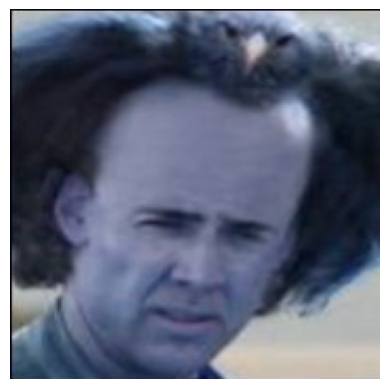

In [ ]:
r = cv2.imread('right/right/right/02109.jpg')
r = cv2.resize(r, (224, 224))

plt.imshow(r.astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import random

# Пример двух списков
list1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Создание пустого списка для выбранных элементов
selected_elements = []

# Пока не будет выбрано 3000 элементов
while len(selected_elements) < 3000:
    # Выбираем случайный элемент из обоих списков
    random_element = random.choice(list1)
    # Проверяем, что этот элемент присутствует и втором списке
    if random_element in list2:
        # Добавляем выбранный элемент в оба списка выбранных элементов
        selected_elements.append(random_element)
        # Удаляем выбранный элемент из списков, чтобы не выбирать его снова
        list1.remove(random_element)
        list2.remove(random_element)

print(selected_elements)

In [ ]:
print(len(x_train_img_1))
print(len(y_train))

3008
3008


In [ ]:
print(y_train[:30])

[1.  0.9 0.8 0.9 0.8 0.8 0.7 1.  1.  1.  0.9 0.8 0.  0.8 0.9 0.  0.7 0.8
 0.  1.  1.  0.  1.  0.9 0.  0.9 0.8 0.  0.8 0.7]


In [ ]:
print(len(x_train_img_1))

508


1


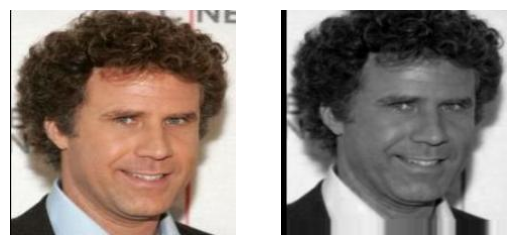

In [ ]:
i = 6
# num = (5 - len(str(i))) * '0'
# num += str(i)
# im1 = cv2.imread(f"left/left_/{num}.jpg")
# im1 = cv2.resize(im1, (224, 224))
# im2 = cv2.imread(f"left/right_/{num}.jpg")
# im2 = cv2.resize(im2, (224, 224))
print(labels[i])
# print(y_train[i])
plt.subplot(121)
plt.imshow(image_pairs[0][i].astype('uint8'), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_pairs[1][i].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print(len(image_pairs))

2


In [ ]:
# x_train_img_1.append(x_train_img_1[12345])
# x_train_img_2.append(x_train_img_1[12345])

# x_train_img_1.append(x_train_img_1[12046])
# x_train_img_2.append(x_train_img_1[12046])

# x_train_img_1.append(x_train_img_1[12645])
# x_train_img_2.append(x_train_img_1[12645])

# x_train_img_1.append(x_train_img_1[11345])
# x_train_img_2.append(x_train_img_1[11345])

In [ ]:
# print(x_train_img_1.shape)
# print(x_train_img_2.shape)

print(len(x_train_img_1))
print(len(x_train_img_2))

81211
81211


In [ ]:
# for i in range(63163):
#     if i > 0:
#         if 63163 % i == 0:
#             print(i)

1
83
761


In [ ]:
a = [1, 3, 4, 5, 7, 8]
print(a[2:4])

[4, 5]


In [ ]:
x_train_img_2 = x_train_img_2[10032:20064]
x_train_img_1 = x_train_img_1[10032:20064]
y_train = y_train[10032:20064]

In [ ]:
# x_train_img_1 = x_train_img_1[:3500]
# x_train_img_2 = x_train_img_2[:3500]
# y_train = y_train[:3500]

x_train_img_1 = np.array(x_train_img_1, dtype=np.float16)
x_train_img_1 /= 255.0
# x_train_img_1 = tf.cast(x_train_img_1, dtype=tf.float16)

x_train_img_2 = np.array(x_train_img_2, dtype=np.float16)
x_train_img_2 /= 255.0
# x_train_img_2 = tf.cast(x_train_img_2, dtype=tf.float16)

print(x_train_img_1.shape)
print(x_train_img_2.shape)
print(y_train.shape)

(10032, 224, 224, 3)
(10032, 224, 224, 3)
(10032,)


In [ ]:
#ФОРМИРОВАНИЕ Y_TRAIN
import random
y_train = []
count = 3
for_shuffle = []
# for i in range(6016):
for i in range(len(x_train_img_1)):
    if i < 12:
        y_train.append(1)
        #print(i)
    else:
        if count == 3:
            y_train.append(0)
            count = 0
            for_shuffle.append(x_train_img_2[i])
        else:
            y_train.append(1)
        count += 1


# count_ones = 0
# for i in range(len(x_train_img_1)):
#     if y_train[i] == 1:
#         count_ones += 1

#         if count_ones > 1 and count_ones <= 7:
#             #others = round(random.uniform(0.8, 0.9), 1)
#             y_train[i] = 0.9
#         # elif count_ones == 6 or count_ones == 7:
#         #     zoom = round(random.uniform(0.7, 0.8), 1)
#         #     y_train[i] = zoom
#         elif count_ones == 9:
#             count_ones = 0


random.shuffle(for_shuffle)

count = 3
id = 0
for i in range(len(x_train_img_1)):
    if i >= 12:
        if count == 3:
            count = 0
            x_train_img_2[i] = for_shuffle[id]
            id += 1

        count += 1
print(id, len(for_shuffle))
y_train = np.array(y_train)

27067 27067


In [ ]:
np.save('left/y_train', np.array(y_train))

In [ ]:
np.save('/content/gdrive/MyDrive/Colab Notebooks/Siamese/y_train', np.array(y_train))

**Модель на основе ResNet50**

In [ ]:
def models_in_parallel(input_shapes):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shapes)
    trainable = False
    for layer in resnet_model.layers:
        # if layer.name == "conv5_block3_3_conv":
        #     trainable = True
        layer.trainable = trainable
    res_out = resnet_model.get_layer('conv5_block3_out').output
    out = Flatten()(res_out)

    # feature_map_shape = res_out.shape[1:]
    # input_layer = layers.Input(shape=feature_map_shape)

    #feature_extractor = Conv2D(64, (3, 3), activation='relu')(input_layer)
    #feature_extractor = MaxPooling2D(pool_size=(2, 2), padding='same')(feature_extractor)
    #feature_extractor = Flatten()(feature_extractor)
    #feature_extractor = Dense(128, activation='relu')(feature_extractor)

    # my_ResNet_model = Model(inputs=resnet_model.input,
    #                   outputs=res_out,
    #                   name='my_ResNet_model')

    # my_model = Model(inputs=input_layer,
    #              outputs=feature_extractor,
    #              name='my_model')

    # Входные данные из базовой модели
    input_tensor = resnet_model.input
    # Выходные данные из новой модели
    #output_tensor = my_model(resnet_model.output)
    # Сборка модели
    model = Model(inputs=input_tensor, outputs=out)

    return model

In [ ]:
import keras.backend as K


def euclidean_distance_loss(vct):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    y_true, y_pred = vct
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def euclidean_distance_loss(y_true, y_pred):
    y_true_float = K.cast(y_true, dtype='float32')
    sum_square = K.sum(K.square(y_pred - y_true_float), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
input_shape = (224, 224, 3)

# # Создаем входы для двух изображений
input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)

# # Создаем базовую сеть
# base_network1 = create_base_network(input_shape)
# #base_network2 = create_base_network(input_shape)

# # Получаем эмбеддинги для каждого изображения
# embedding1 = base_network1(input_image1)
# embedding2 = base_network1(input_image2)

# # Вычисляем "расстояние" между эмбеддингами
# distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])


first_model = models_in_parallel(input_shape)
# second_model = models_in_parallel(input_shape)

# for layer in second_model.layers:
#     layer._name = "second_" + layer.name

embedding1 = first_model(input_image1)
embedding2 = first_model(input_image2)
# concat = concatenate([dense_relu_2, dense_sigmoid_2])
embedded_distance = layers.Subtract(name='subtract_embeddings')([embedding1, embedding2])
# distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])
embedded_distance = layers.Lambda(lambda x: K.sum(K.abs(x),
                                    axis=-1, keepdims=True),
                                    name='euclidean_distance')(embedded_distance)
# distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])
# distance = euclidean_distance(embedding1, embedding2)
# output_tensor1 = first_model.output
# output_tensor2 = second_model.output

#distance = Lambda(euclidean_distance)([output_tensor1, output_tensor2])
#distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([output_tensor1, output_tensor2])
# output = Dense(128, activation='relu')(distance)
# output = Dense(64, activation='relu')(output)
output = Dense(16, activation='relu')(embedded_distance)
output = Dense(1, activation='sigmoid')(output)

# my_model_2 = Model(inputs=first_model.input,
#                  outputs=output,
#                  name='my_model_2')

# output_tensor1_ = my_model_2(first_model.output)

siamese_model = Model(inputs=[input_image1, input_image2],
                      outputs=output,
                      name='siamese_model')

print(siamese_model.summary())
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#siamese_model.compile(optimizer='adam', loss=euclidean_distance_loss, metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step
Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 100352)               2358771   ['input_1[0][0]',             
                                                          2          'input_2[0][0]']             
                                                                                                  
 subtract_embeddings 

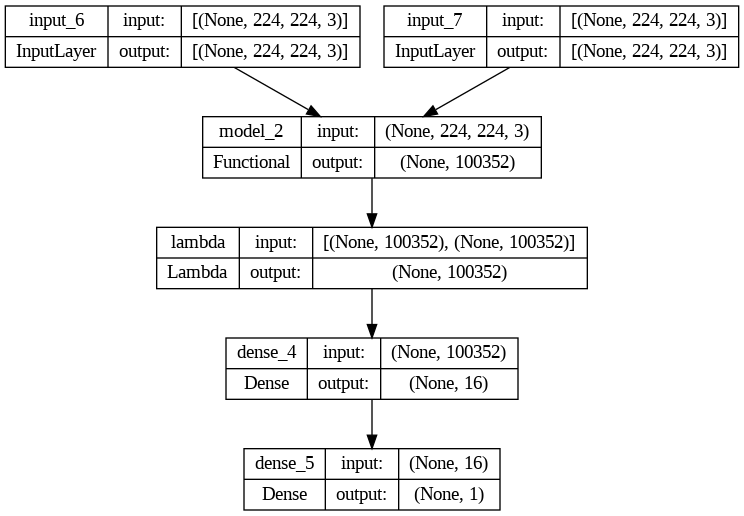

In [ ]:
keras.utils.plot_model(siamese_model, "my_first_model.png", show_shapes=True)

**Собственная модель**

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.models import Model

def create_siamese_network(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_network = create_base_network(input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance, output_shape=euclidean_distance_output_shape)([processed_a, processed_b])
    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)

    return model

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    model = Model(input, x)

    return model

input_shape = (224, 224, 3)
siamese_model = create_siamese_network(input_shape)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Функция для создания базовой сети (вариант одинаков для обоих изображений)
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Dropout(0.05)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Dropout(0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='last_of_conv')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    # x = Dropout(0.15)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', name='last_of_FC')(x)
    # return Model(inputs=input, outputs=x, name='base_model')
    return Model(inputs=input, outputs=x)

In [ ]:
# Задаем размерность изображений
input_shape = (224, 224, 3)

# Создаем входы для двух изображений
input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)

# Создаем базовую сеть
base_network1 = create_base_network(input_shape)
# base_network2 = create_base_network(input_shape)

# Получаем эмбеддинги для каждого изображения
embedding1 = base_network1(input_image1)
embedding2 = base_network1(input_image2)

# Вычисляем "расстояние" между эмбеддингами
# embedded_distance = layers.Subtract(name='subtract_embeddings')([embedding1, embedding2])
distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])
# embedded_distance = layers.Lambda(lambda x: K.sum(K.abs(x),
#                                     axis=-1, keepdims=True),
#                                     name='euclidean_distance')(embedded_distance)
# dst = distance.euclidean(embedding1, embedding2)

#distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True)))([embedding1, embedding2])

# Добавляем выходной слой, который будет указывать на схожесть изображений
# output = Dense(54, activation='relu')(distance)
# output = Dropout(0.3)(output)
# output = Dense(26, activation='relu')(output)
# output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(distance)

# Создаем модель с двумя входами и одним выходом
# adam_optimizer = keras.optimizers.Adam(learning_rate=0.00001)
siamese_model = Model(inputs=[input_image1, input_image2], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
layer_name = siamese_model.get_layer('base_model')
print(layer_name.get_layer('last_of_conv'))

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from keras import backend as K

# # Замораживаем все слои в существующей модели
# for layer in base_network1.layers:
#     layer.trainable = False

# Создаем слои для новой модели
layer_name = siamese_model.get_layer('base_model')
x = layer_name.get_layer('last_of_conv').output
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
# output = Dense(1, activation='sigmoid')(x)

# Создаем новую модель
new_model = Model(inputs=siamese_model.input, outputs=x)

# Объединяем старую модель и новую модель в одну сиамскую модель
input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)
embedding1 = siamese_model(input_image1)
embedding2 = siamese_model(input_image2)
output1 = new_model(embedding1)
output2 = new_model(embedding2)

# Создаем конечный сиамский слой, который предсказывает близость между парами
distance = Lambda(lambda x: K.abs(x[0] - x[1]))([output1, output2])
final_output = Dense(1, activation='sigmoid')(distance)

siamese_new_model = Model(inputs=[input_image1, input_image2], outputs=final_output)
siamese_new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_14'), name='input_14', description="created by layer 'input_14'") at layer "conv2d_15". The following previous layers were accessed without issue: []

In [ ]:
layer_name = siamese_model.get_layer('base_model')
for i in layer_name.layers:
    print(i)

In [ ]:
# Замораживаем все слои базовой сети, кроме "last_of_conv"
# for layer in base_network1.layers:
#     if layer.name != 'last_of_conv':
#         layer.trainable = False

# Создаем новую сеть на основе "last_of_conv"
layer_name = siamese_model.get_layer('base_model')
x = layer_name.get_layer('last_of_conv').output
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output_new = x

# Входы для новой сети
input_image1_new = Input(shape=input_shape)
input_image2_new = Input(shape=input_shape)

# Подаем выход "last_of_conv" на новую сеть
embedding1_new = Model(inputs=input_image1, outputs=layer_name.get_layer('last_of_conv').output)(input_image1_new)
embedding2_new = Model(inputs=input_image2, outputs=layer_name.get_layer('last_of_conv').output)(input_image2_new)

# Вычисляем расстояние между embedding1_new и embedding2_new
distance_new = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1_new, embedding2_new])
output_new = Dense(1, activation='sigmoid')(distance_new)

# Создаем новую сиамскую модель
siamese_model_new = Model(inputs=[input_image1_new, input_image2_new], outputs=output_new)

# Компилируем модель
siamese_model_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_14'), name='input_14', description="created by layer 'input_14'") at layer "conv2d_15". The following previous layers were accessed without issue: []

In [ ]:
# def cr_model():
#     # Задаем размерность изображений
#     input_shape = (224, 224, 3)

#     # Создаем входы для двух изображений
#     input_image1 = Input(shape=input_shape)
#     input_image2 = Input(shape=input_shape)

#     # Создаем базовую сеть
#     base_network1 = create_base_network(input_shape)
#     base_network2 = create_base_network(input_shape)

#     # Получаем эмбеддинги для каждого изображения
#     embedding1 = base_network1(input_image1)
#     embedding2 = base_network2(input_image2)

#     # Вычисляем "расстояние" между эмбеддингами
#     distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])

#     # Добавляем выходной слой, который будет указывать на схожесть изображений
#     # output = Dense(54, activation='relu')(distance)
#     # output = Dropout(0.3)(output)
#     # output = Dense(26, activation='relu')(output)
#     # output = Dropout(0.2)(output)
#     output = Dense(1, activation='sigmoid')(distance)

#     # Создаем модель с двумя входами и одним выходом
#     adam_optimizer = keras.optimizers.Adam(learning_rate=0.00001)
#     siamese_model = Model(inputs=[input_image1, input_image2], outputs=output)
#     siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return siamese_model

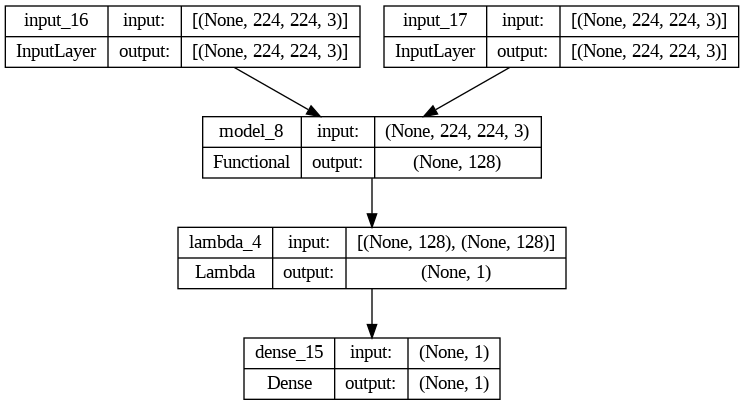

In [ ]:
keras.utils.plot_model(siamese_model, "my_first_model.png", show_shapes=True)

**Обучение**

In [ ]:
# path = '/content/gdrive/MyDrive/Colab Notebooks/Siamese/Siamese(8)/weights.{epoch:02d}.h5'
path = 'weights.{epoch:02d}.h5'
model_checkpoint = ModelCheckpoint(filepath=path, # Путь к файлу весов
                             save_weights_only=True, # Сохранять только веса модели
                             save_freq=2)

In [ ]:
# adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
    if epoch % 6 == 0 and epoch != 0 and epoch <= 12:
        lr = lr * 0.5  # Уменьшаем learning rate в два раза каждую десятую эпоху
    elif epoch > 12:
        if epoch % 3 == 0:
            lr = lr * 0.5
    return lr

# Создаем callback для изменения learning rate
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
history = siamese_model.fit_generator(generator=siamese_generator.generate(),
                                      steps_per_epoch=6016//32)
                                      #epochs=10)

TypeError: SiameseImageGenerator.generate() missing 1 required positional argument: 'index'

In [ ]:
# print(tf.config.list_physical_devices())

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# # Open a strategy scope.
with strategy.scope():
  # Everything that creates variables should be under the strategy scope.
  # In general this is only model construction & `compile()`.
  model = cr_model()
  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on all available devices.
history = model.fit([x_train_img_1, x_train_img_2], y_train,
                            batch_size=2,#изменить и шаг тоже(динамичный)
                            epochs=30,
                            validation_split=0.25,
                            # use_multiprocessing=True,
                            shuffle=True,
                            callbacks=model_checkpoint)

# # Test the model on all available devices.
# model.evaluate(test_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
#generator
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
# from keras.preprocessing.image import img_to_array

def load_images(image_paths):
    images = []
    for path in image_paths:#два
        for letter in path:
            if letter == "\\":
                path = path.replace(letter,"/")
        #print(path)
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)# / 255.0  # Нормализация до [0, 1]
        images.append(image)
    return np.array(images)

def siamese_data_generator(folder1, folder2, y_train, batch_size):
    while True:
        image_paths1 = [os.path.join(folder1, image) for image in os.listdir(folder1)]
        image_paths2 = [os.path.join(folder2, image) for image in os.listdir(folder2)]
        # print(image_paths1)
        # print(image_paths2)
        pairs = []
        labels = []

        for _ in range(batch_size):
            same_pair = np.random.choice(np.where(y_train == 1)[0], 1, replace=False)#пара одинаковых
            diff_pair = np.random.choice(np.where(y_train == 0)[0], 1, replace=False)#пара разных

            # same_pair = np.random.choice(y_train[y_train == 1].index, 2, replace=False)
            # diff_pair = np.random.choice(y_train[y_train == 0].index, 2, replace=False)

            image1 = load_images([image_paths1[same_pair[0]], image_paths2[same_pair[0]]])#два одинаковых изображения
            pairs.append(image1)
            labels.append(1)  # сходные изображения

            image2 = load_images([image_paths1[diff_pair[0]], image_paths2[diff_pair[0]]])#два различных изображения
            pairs.append(image2)
            labels.append(0)  # различные изображения

        pairs = np.array(pairs)
        pairs = pairs.transpose((1, 0, 2, 3, 4))
        #yield np.array([pairs[:,0], pairs[:,1]]), np.array(labels)
        # yield np.array([pairs[0], pairs[1]]), np.array(labels)
        yield [pairs[0], pairs[1]], np.array(labels)

# Путь к папкам с изображениями и массиву y_train
folder1 = 'left/left_'
folder2 = 'left/right_'
y_train = np.load('left/y_train.npy')

batch_size = 208
train_generator = siamese_data_generator(folder1, folder2, y_train, batch_size)

# # Получение одного batch данных из генератора
# batch_data = next(train_generator)

# image, labels_batch = batch_data

# # Печать размера полученного batch
# print("Images batch shape:", image[0].shape)
# # print("Images batch shape:", image_2.shape)
# print("Labels batch shape:", labels_batch.shape)

# Использование генератора данных для обучения модели Siamese NN
# model.fit_generator(train_generator, ...)

**Генератор для COLAB**

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
def load_images(image_paths, flag):
    images = []
    path = image_paths

    for letter in path:
        if letter == "\\":
            path = path.replace(letter,"/")
    # print(path, '---')
    if flag == 1:
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        images.append(image)

        augmentations = [datagen__, datagen_, datagen, 'none']
        selected_augmentation = random.choice(augmentations)
        if selected_augmentation != 'none':
            # image = load_img(path, target_size=(224, 224))
            image = cv2.imread(path)[:,:,::-1]
            image = cv2.resize(image, (224, 224))

            augmented_image = selected_augmentation.random_transform(image)
            #print('-0-0')
            augmented_image = img_to_array(augmented_image) / 255.0
            images.append(augmented_image)
        else:
            images.append(image)

    else:
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        images.append(image)

        random_number = random.randint(0, 6015)
        num = (5 - len(str(random_number))) * '0'
        num += str(random_number)

        image = load_img(f"/content/gdrive/MyDrive/Colab Notebooks/Siamese/right/{num}.jpg", target_size=(224, 224))
        image = img_to_array(image) / 255.0
        images.append(image)

    return np.array(images)

In [ ]:
from tensorflow.keras.utils import Sequence

class SiameseDataGenerator(Sequence):
    def __init__(self, folder1, y_train, batch_size):
        self.folder1 = folder1
        # self.folder2 = folder2
        self.y_train = y_train
        self.batch_size = batch_size
        self.indexes = np.arange(len(y_train))

    def __len__(self):
        return len(self.y_train) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # print(indexes)
        image_paths1 = [os.path.join(self.folder1, image) for image in os.listdir(self.folder1)]
        # image_paths2 = [os.path.join(self.folder2, image) for image in os.listdir(self.folder2)]

        pairs = []
        labels = []

        for i in indexes:
            if i % 2 == 0:
                diff_pair = np.random.choice(np.where(self.y_train == 0)[0], 1, replace=False)
                image2 = load_images(image_paths1[diff_pair[0]], 0)
                pairs.append(image2)
                labels.append(0)
            else:
                same_pair = np.random.choice(np.where(self.y_train == 1)[0], 1, replace=False)
                # print(image_paths1[same_pair[0]])
                image1 = load_images(image_paths1[same_pair[0]], 1)
                pairs.append(image1)
                labels.append(1)

        return [np.array(pairs)[:, 0], np.array(pairs)[:, 1]], np.array(labels)

# Использование SiameseDataGenerator
folder1 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/left"
# folder2 = "/content/gdrive/MyDrive/Colab Notebooks/Siamese/right"
# folder1 = 'left/left_'
# folder2 = 'left/right_'
y_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/Siamese/y_train.npy')
batch_size = 208

train_generator = SiameseDataGenerator(folder1, y_train, batch_size)


# # # Получение одного batch данных
# test_batch = train_generator[0]

# # Разделение данных из batch на пары изображений и соответствующие метки
# image_pairs, labels = test_batch

# # Печать формы полученного batch
# print("Shape of image pairs:", np.array(image_pairs).shape)  # Форма первой пары изображений
# print("Shape of labels:", labels.shape)  # Форма меток

#history = siamese_model.fit(train_generator, epochs=30, steps_per_epoch=len(y_train)//batch_size, use_multiprocessing=True, callbacks=model_checkpoint)

**Генератор для A100**

In [ ]:
try:
    DataSequence = get_keras_submodule('utils').Sequence
except:
    try:
        # Work-around for TF-2.9
        from keras.utils.data_utils import Sequence
        DataSequence = Sequence
    except:
        DataSequence = object

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
import random
def load_images(image_paths):
    images = []
    for path in image_paths:#два
        for letter in path:
            if letter == "\\":
                path = path.replace(letter,"/")
        # print(path)
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        images.append(image)
    return np.array(images)

In [ ]:
# from tensorflow.keras.utils import Sequence

class SiameseDataGenerator(Sequence):
    def __init__(self, folder1, folder2, y_train, batch_size):
        self.folder1 = folder1
        self.folder2 = folder2
        self.y_train = y_train
        self.batch_size = batch_size
        self.indexes = np.arange(len(y_train))

        self.image_paths1 = [os.path.join(self.folder1, image) for image in os.listdir(self.folder1)]
        self.image_paths2 = [os.path.join(self.folder2, image) for image in os.listdir(self.folder2)]
        # self.image_paths1 = self.image_paths1[1:]

        print(len(self.image_paths1) == len(self.image_paths2))
    def __len__(self):
        return len(self.y_train) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # print(indexes)

        #print(len(image_paths1) == len(image_paths2))
        random.shuffle(indexes)

        # zipped = list(zip(indexes, image_paths1, image_paths2))
        # random.shuffle(zipped)
        # indexes, image_paths1, image_paths2 = zip(*zipped)

        pairs = []
        labels = []

        for i in indexes:
            #print(y_train[i], image_paths1[i], image_paths2[i])
            image2 = load_images([self.image_paths1[i], self.image_paths2[i]])
            pairs.append(image2)
            labels.append(y_train[i])
            # if i % 2 == 0:
            #     diff_pair = np.random.choice(np.where(self.y_train == 0)[0], 1, replace=False)
            #     # iff_pair
            #     image2 = load_images([image_paths1[diff_pair[0]], image_paths2[diff_pair[0]]])
            #     pairs.append(image2)
            #     labels.append(0)
            # else:
            #     same_pair = np.random.choice(np.where(self.y_train == 1)[0], 1, replace=False)
            #     image1 = load_images([image_paths1[same_pair[0]], image_paths2[same_pair[0]]])
            #     pairs.append(image1)
            #     labels.append(1)

        return [np.array(pairs)[:, 0], np.array(pairs)[:, 1]], np.array(labels)

In [ ]:
# from tensorflow.keras.utils import Sequence

class SiameseValGenerator(Sequence):
    def __init__(self, folder1_, folder2_, y_train_, batch_size):
        self.folder1_ = folder1_
        self.folder2_ = folder2_
        self.y_train_ = y_train_
        self.batch_size_ = batch_size
        self.indexes_ = np.arange(len(y_train_))

        self.image_paths1_ = [os.path.join(self.folder1_, image_) for image_ in os.listdir(self.folder1_)]
        self.image_paths2_ = [os.path.join(self.folder2_, image_) for image_ in os.listdir(self.folder2_)]
        # self.image_paths1_ = self.image_paths1_[1:]

        print(len(self.image_paths1_) == len(self.image_paths2_))
    def __len__(self):
        return len(self.y_train_) // self.batch_size_

    # def __getitem__(self, index_):
    #     indexes_ = self.indexes_[index_*self.batch_size_:(index_+1)*self.batch_size_]

    #     # print(indexes)

    #     #image_paths1 = image_paths1[1:]

    #     #print(len(image_paths1) == len(image_paths2))
    #     random.shuffle(indexes_)

    #     # zipped = list(zip(indexes, image_paths1, image_paths2))
    #     # random.shuffle(zipped)
    #     # indexes, image_paths1, image_paths2 = zip(*zipped)

    #     pairs_ = []
    #     labels_ = []

    #     for i in indexes_:
    #         #print(y_train[i], image_paths1[i], image_paths2[i])
    #         image2_ = load_images([self.image_paths1_[i], self.image_paths2_[i]])
    #         pairs_.append(image2_)
    #         labels_.append(y_train_[i])
    #         # if i % 2 == 0:
    #         #     diff_pair = np.random.choice(np.where(self.y_train == 0)[0], 1, replace=False)
    #         #     # iff_pair
    #         #     image2 = load_images([image_paths1[diff_pair[0]], image_paths2[diff_pair[0]]])
    #         #     pairs.append(image2)
    #         #     labels.append(0)
    #         # else:
    #         #     same_pair = np.random.choice(np.where(self.y_train == 1)[0], 1, replace=False)
    #         #     image1 = load_images([image_paths1[same_pair[0]], image_paths2[same_pair[0]]])
    #         #     pairs.append(image1)
    #         #     labels.append(1)

    #     return [np.array(pairs_)[:, 0], np.array(pairs_)[:, 1]], np.array(labels_)

    def __getitem__(self, index_):
        indexes_ = self.indexes_[index_*self.batch_size_:(index_+1)*self.batch_size_]
        # print(indexes_)
        image_paths1_ = [os.path.join(self.folder1_, image) for image in os.listdir(self.folder1_)]
        image_paths2_ = [os.path.join(self.folder2_, image) for image in os.listdir(self.folder2_)]

        pairs_ = []
        labels_ = []

        for i in indexes_:
            rand = random.randint(1, 2)
            if rand % 2 == 0:
                diff_pair_ = np.random.choice(np.where(self.y_train_ == 0)[0], 1, replace=False)
                image2_ = load_images([image_paths1_[diff_pair_[0]], image_paths2_[diff_pair_[0]]])
                pairs_.append(image2_)
                labels_.append(0)
            else:
                same_pair_ = np.random.choice(np.where(self.y_train_ == 1)[0], 1, replace=False)
                image1_ = load_images([image_paths1_[same_pair_[0]], image_paths2_[same_pair_[0]]])
                pairs_.append(image1_)
                labels_.append(1)

        return [np.array(pairs_)[:, 0], np.array(pairs_)[:, 1]], np.array(labels_)

In [ ]:
# Использование SiameseDataGenerator
folder1 = 'left/left_saug'
folder2 = 'left/right_saug'
y_train = np.load('left/y_train.npy')
y_train_ = np.load('right/y_train_waug.npy')

folder1_ = 'right/left_waug'
folder2_ = 'right/right_waug'
batch_size = 256
batch_size_ = 32

train_generator = SiameseDataGenerator(folder1, folder2, y_train, batch_size)
validation_generator = SiameseValGenerator(folder1_, folder2_, y_train_, batch_size_)
#validation_generator = SiameseDataGenerator(folder1, folder2, y_train, batch_size)

# # Получение одного batch данных
test_batch = train_generator[0]
image_pairs, labels = test_batch

val_batch = validation_generator[0]
image_pairs_, labels_ = val_batch

# Печать формы полученного batch
# print("Shape of image pairs:", np.array(image_pairs).shape)  # Форма первой пары изображений
# print("Shape of labels:", labels.shape)  # Форма меток

#history = siamese_model.fit(train_generator, epochs=30, steps_per_epoch=len(y_train)//batch_size, use_multiprocessing=True, callbacks=model_checkpoint)


True
True


In [ ]:
for i in range(350):
    print(i)
    test_batch = train_generator[i]
    image_pairs, labels = test_batch
    print(image_pairs[0].shape, image_pairs[1].shape, labels.shape)

    # val_batch = validation_generator[i]
    # image_pairs_, labels_ = val_batch
    # print(image_pairs_[0].shape, image_pairs_[1].shape, labels_.shape)

0
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
1
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
2
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
3
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
4
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
5
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
6
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
7
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
8
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
9
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
10
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
11
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
12
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
13
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
14
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
15
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
16
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
17
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
18
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
19
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
20
(256, 224, 224, 3) (256, 224, 224, 3) (256,)
21

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Установка настроек для multiprocessing
import multiprocessing
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.intra_op_parallelism_threads = multiprocessing.cpu_count()
config.inter_op_parallelism_threads = multiprocessing.cpu_count()
session = tf.compat.v1.Session(config=config)

In [ ]:
def scheduler(epoch, lr):
    if epoch % 6 == 0 and epoch != 0 and epoch <= 12:
        lr = lr * 0.5  # Уменьшаем learning rate в два раза каждую десятую эпоху
    elif epoch > 12:
        if epoch % 3 == 0:
            lr = lr * 0.5
    return lr

# Создаем callback для изменения learning rate
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
with tf.device('/GPU:0' and '/GPU:1'):
    history = siamese_model.fit(train_generator,
                                epochs = 50,
                                steps_per_epoch=316,
                                #use_multiprocessing = True,
                                validation_data=validation_generator,
                                validation_steps=186,
                                callbacks=[model_checkpoint, lr_scheduler])

Epoch 1/50


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
with tf.device('/GPU:0' and '/GPU:1'):
    history = siamese_model.fit([x_train_img_1, x_train_img_2], y_train,
                                batch_size=152,#изменить и шаг тоже(динамичный)
                                epochs=10,
                                validation_split=0.25,
                                #use_multiprocessing=True,
                                shuffle=True,
                                callbacks=model_checkpoint)

Epoch 1/10
50/50 [==============================] - 21s 353ms/step - loss: 0.2548 - accuracy: 0.9229 - val_loss: 0.2365 - val_accuracy: 0.9342
Epoch 2/10
50/50 [==============================] - 12s 232ms/step - loss: 0.2405 - accuracy: 0.9294 - val_loss: 0.2281 - val_accuracy: 0.9354
Epoch 3/10
50/50 [==============================] - 11s 231ms/step - loss: 0.2321 - accuracy: 0.9322 - val_loss: 0.2235 - val_accuracy: 0.9370
Epoch 4/10
50/50 [==============================] - 11s 230ms/step - loss: 0.2259 - accuracy: 0.9354 - val_loss: 0.2200 - val_accuracy: 0.9374
Epoch 5/10
50/50 [==============================] - 11s 228ms/step - loss: 0.2210 - accuracy: 0.9371 - val_loss: 0.2169 - val_accuracy: 0.9382
Epoch 6/10
50/50 [==============================] - 10s 195ms/step - loss: 0.2170 - accuracy: 0.9393 - val_loss: 0.2144 - val_accuracy: 0.9386
Epoch 7/10
50/50 [==============================] - 11s 230ms/step - loss: 0.2136 - accuracy: 0.9411 - val_loss: 0.2126 - val_accuracy: 0.9394

In [ ]:
print(tf.config.experimental.get_memory_info('/GPU:0'))
print(tf.config.experimental.get_memory_info('/GPU:1'))

{'current': 267659776, 'peak': 282522112}
{'current': 5376, 'peak': 3757677824}


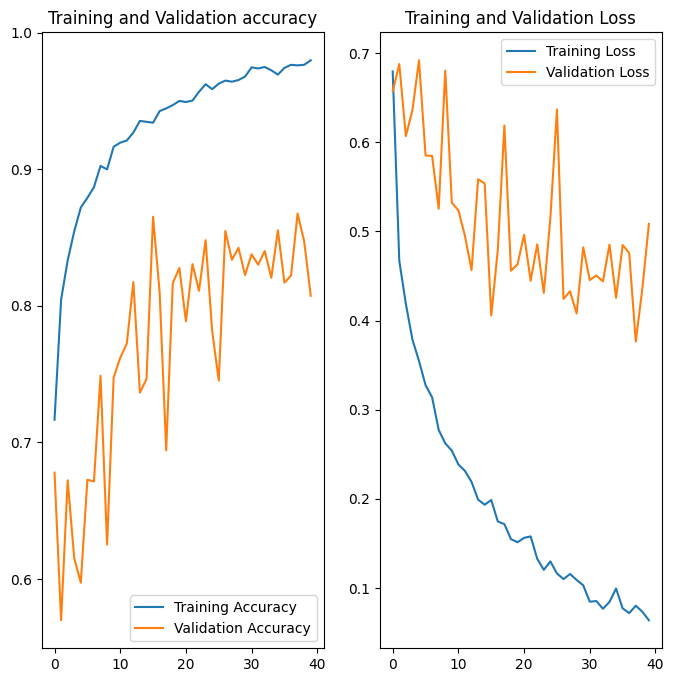

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("3_Training and Validation Accuracy and Loss.png", dpi=150)
plt.show()

In [ ]:
siamese_model.save('/content/gdrive/MyDrive/Colab Notebooks/Siamese/clear models/clearRes_.h5')
# siamese_model.save('clearRes.h5')

In [ ]:
siamese_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Siamese/Siamese(9).keras', compile=False, safe_mode=False)
# siamese_model = load_model('clearRes2.h5', compile=False)
#print(siamese_model.summary())

In [ ]:
siamese_model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/Siamese/rdySiamese(10)w16.h5')
# siamese_model.load_weights('weights.05.h5')

In [ ]:
# # Функция для создания базовой сети (вариант одинаков для обоих изображений)
# def create_base_network(input_shape):
#     input = Input(shape=input_shape)
#     x = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='last_of_conv')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dense(32, activation='relu', name='last_of_FC')(x)
#     return Model(input, x, name='base_model')



# # Задаем размерность изображений
# input_shape = (224, 224, 3)

# # Создаем входы для двух изображений
# input_image1 = Input(shape=input_shape)
# input_image2 = Input(shape=input_shape)

# # Создаем базовую сеть
# base_network = create_base_network(input_shape)

# # Получаем эмбеддинги для каждого изображения
# embedding1 = base_network(input_image1)
# embedding2 = base_network(input_image2)

# # Вычисляем "расстояние" между эмбеддингами
# distance = Lambda(lambda x: K.abs(x[0] - x[1]))([embedding1, embedding2])

# # Добавляем выходной слой, который будет указывать на схожесть изображений
# # output = Dense(54, activation='relu')(distance)
# # output = Dropout(0.3)(output)
# # output = Dense(26, activation='relu')(output)
# # output = Dropout(0.2)(output)
# output = Dense(1, activation='sigmoid')(distance)

# # Создаем модель с двумя входами и одним выходом
# siamese_model = Model(inputs=[input_image1, input_image2], outputs=output)
# siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
trainable = False
layer_name = siamese_model.get_layer('base_model')
for layer in layer_name.layers:
    if layer.name == "last_of_conv":
        trainable = True
    print(layer)
    layer.trainable = trainable

In [ ]:
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 32)           4237440     ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

**Проверка**

In [ ]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
print(new_av[i])

[ 23.36909461  65.10477686 108.79668617 188.52004194]


In [ ]:
path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBZ6fKT-tY.jpg'
# path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/riscvvv.jpg'
# path_to_full_img = 'fruits.jpg'
# Загрузка изображения
image = cv2.imread(path_to_full_img)
image = cv2.resize(image, (224, 224))

for i in range(len(new_av)):

    #coord = [78.0, 68.0, 118.0, 138.0]
    # coord = [75.0, 55.0, 120.0, 90.0]
    # coord1 = [130, 100, 160, 160]
    x1, y1, x2, y2 = new_av[i]

    # Вырезание объекта из изображения
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)

    # print(i)
    object_image = image[y1:y2, x1:x2]
    cv2.imwrite(str(i)+'.jpg', object_image)

# x1, y1, x2, y2 = coord1
# Вырезание объекта из изображения
# x1 = int(x1)
# x2 = int(x2)
# y1 = int(y1)
# y2 = int(y2)

# newIm = image[y1:y2, x1:x2]
# Сохранение вырезанного объекта
# cv2.imwrite('pred.jpg', object_image)
# cv2.imwrite('pred123.jpg', newIm)

In [ ]:
# path_to_obj_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBdddZ6fKT-tY(1).jpg'
path_to_obj_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBbbbZ6fKT-tY.jpg'
# path_to_obj_img = '/content/gdrive/MyDrive/Colab Notebooks/riscvvv_copy(1).jpg'
# path_to_obj_img = '/content/gdrive/MyDrive/Colab Notebooks/jostic.jpg'
# path_to_obj_img = 'fruits_copy.jpg'
#path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/RPN/train/IMG20230910182523_jpg.rf.fea510241bdefc7cd956697325e2872e.jpg'
#path_to_pred_img = 'pred.jpg'

object_img = cv2.imread(path_to_obj_img)[:,:,::-1]
object_img = cv2.resize(object_img, (224, 224))
#object_img = increase_brightness(object_img, 20)
cv2.imwrite('obj_img.jpg', object_img)
object_img = object_img.astype('float16') / 255

# predicted_img = cv2.imread(path_to_pred_img)
# predicted_img = cv2.resize(predicted_img, (64, 64))
# predicted_img = predicted_img.astype('float32') / 255

# predicted_img123 = cv2.imread('pred123.jpg')
# predicted_img123 = cv2.resize(predicted_img123, (64, 64))
# predicted_img123 = predicted_img123.astype('float32') / 255


object_img = np.expand_dims(object_img, axis=0)
# predicted_img = np.expand_dims(predicted_img, axis=0)
# predicted_img123 = np.expand_dims(predicted_img123, axis=0)

In [ ]:
predicted_img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/jostic.jpg')
predicted_img = cv2.resize(predicted_img, (224, 224))
predicted_img = predicted_img.astype('float16') / 255
predicted_img = np.expand_dims(predicted_img, axis=0)
predictions = siamese_model.predict([object_img, object_img])
print(predictions)

1/1 [==============================] - 1s 948ms/step
[[0.9874583]]


In [ ]:
pred = []
# for i in range(len(new_av)):
for i in range(len(new_av)):#727
    predicted_img = cv2.imread(str(i)+'.jpg')#[:,:,::-1]
    predicted_img = cv2.resize(predicted_img, (224, 224))
    if i == 100: cv2.imwrite('pred_img.jpg', predicted_img)
    predicted_img = predicted_img.astype('float16') / 255
    predicted_img = np.expand_dims(predicted_img, axis=0)

    predictions = siamese_model.predict([object_img, predicted_img])
    pred.append(predictions)

print(len(pred))

1/1 [==============================] - 0s 77ms/step
846


In [ ]:
for i in range(len(pred)):
    if pred[i] > 0.8:
        print(i)
        # print(pred[i])
        # print(new_av[i])
        # break

max_value = max(pred)
max_index = pred.index(max_value)

print(f'max_value - {max_value}, id - {max_index}')

max_value - [[0.7319637]], id - 48


In [ ]:
print(pred[110])

[[0.00191635]]


[114.55062962  32.64798579 163.29065686 111.29729831]
[[0.08160023]]


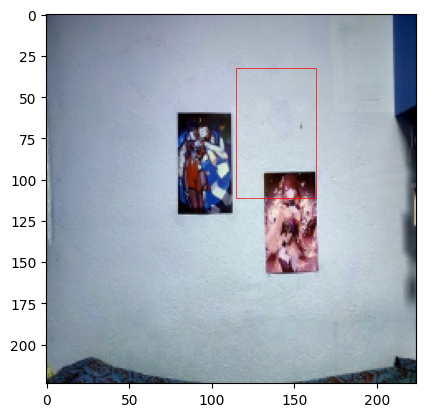

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/rPBZ6fKT-tY.jpg'
# path_to_full_img = '/content/gdrive/MyDrive/Colab Notebooks/riscvvv.jpg'
# path_to_full_img = 'fruits.jpg'

object_img = cv2.imread(path_to_full_img)#[:,:,::-1]
object_img = cv2.resize(object_img, (224, 224))

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(object_img)

i = max_index
# i = 424
print(new_av[i])
print(pred[i])
# Добавление прямоугольника на график
rect = patches.Rectangle((new_av[i][0], new_av[i][1]), new_av[i][2] - new_av[i][0], new_av[i][3] - new_av[i][1], linewidth=0.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# ii = (i + 1) * 4
# jj = ii - 4
# Отображение графика
plt.show()
#print(offsets[0][jj:ii])

# **Обучение на TPU**

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.15.0


BaseException: ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!

# **Мусор**

In [ ]:
#------------------------------------------------------------------------------------------------------------
#/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
#------------------------------------------------------------------------------------------------------------
# def create_model(num_classes):
#     # Загрузка предварительно обученной модели ResNet50 без головного слоя
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Замораживаем базовую модель, чтобы сохранить ее предварительные обученные веса
#     base_model.trainable = False

#     # Создаем слои Region Proposal Network (RPN)
#     rpn_conv = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(base_model.output)
#     rpn_cls = layers.Conv2D(9, (1, 1), activation='sigmoid')(rpn_conv)
#     rpn_reg = layers.Conv2D(36, (1, 1))(rpn_conv)

#     # Подключаем выход RPN к модели
#     rpn_model = Model(inputs=base_model.input, outputs=[rpn_cls, rpn_reg])

#     # Создаем классификатор обнаруженных объектов
#     roi_input = layers.Input(shape=(7, 7, 512))
#     roi_pooling = layers.MaxPooling2D((2, 2))(roi_input)
#     flatten = layers.Flatten()(roi_pooling)
#     fc1 = layers.Dense(4096, activation='relu')(flatten)
#     fc2 = layers.Dense(4096, activation='relu')(fc1)
#     cls_output = layers.Dense(num_classes, activation='softmax')(fc2)
#     reg_output = layers.Dense(num_classes * 4, activation='linear')(fc2)

#     # Подключаем вход классификатора к RPN
#     classifier_model = Model(inputs=roi_input, outputs=[cls_output, reg_output])

#     # Подключаем RPN и основную модель для обнаружения и классификации объектов
#     image_input = base_model.input
#     rpn_output = rpn_model(image_input)
#     roi_output = layers.MaxPooling2D(7, 7)([image_input, rpn_output[0]])
#     object_cls_output, object_reg_output = classifier_model(roi_output)

#     # Объявляем модель Faster R-CNN
#     model = Model(inputs=image_input, outputs=[object_cls_output, object_reg_output])

#     return model

In [ ]:
# # Создаем экземпляр модели
# num_classes = 2
# model = create_model(num_classes)

# # Компилируем модель с выбранными функциями потерь и оптимизатором
# model.compile(
#     loss=['categorical_crossentropy', 'mse'],
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

In [ ]:
# def build_model():
#     vgg16 = VGG16(include_top=False, input_shape=(300, 300, 3))

#     # слои конволюционной части модели
#     conv4_3 = vgg16.get_layer('block4_conv3').output
#     fc7 = vgg16.get_layer('block5_conv3').output
#     conv6 = Conv2D(1024, (3, 3), padding='same', activation='relu')(fc7)
#     conv7 = Conv2D(1024, (1, 1), padding='same', activation='relu')(conv6)

#     # additional feature maps
#     conv8_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv7)
#     conv8_2 = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv8_1)

#     conv9_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv8_2)
#     conv9_2 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv9_1)

#     conv10_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv9_2)
#     conv10_2 = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv10_1)

#     conv11_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv10_2)
#     conv11_2 = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv11_1)

#     # соединение feature maps
#     merged_layers = concatenate([conv4_3, conv7, conv8_2, conv9_2, conv10_2, conv11_2], axis=-1)

#     return Model(vgg16.input, merged_layers)

In [ ]:
# def build_ssd_model():
#     base_model = build_model()

#     # слои для предсказания bounding boxes и классов
#     x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', activation='relu')(base_model.output)
#     x = Conv2D(1024, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)

#     # слои для предсказания bounding boxes
#     bbox_output = Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)

#     # слои для предсказания классов
#     class_output = Conv2D(2, (3, 3), strides=(1, 1), padding='same', activation='softmax')(x)

#     return Model(base_model.input, [bbox_output, class_output])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 8)                 16        
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17    

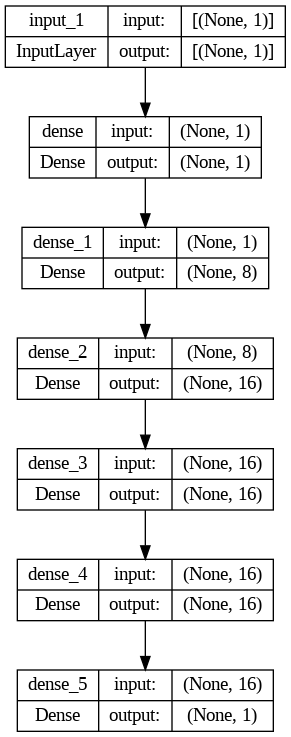

In [ ]:
input_shape=(1)
inputs = Input(shape=(input_shape))

x = Dense(1, activation='linear')(inputs)
x = Dense(8, activation='linear')(x)
x = Dense(16,  activation = 'linear')(x)
x = Dense(16,  activation = 'linear')(x)
x = Dense(16,  activation = 'linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=x)

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics='accuracy'
)

model.summary()
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

In [ ]:
x = np.array([0, 1, 2, 3, 4, 5, 21, 14, 15, 45, 51, 83])
y = np.array([32, 33.8, 35.6, 37.4, 39.2, 41, 69.8, 57.2, 59, 113, 123.8, 181.4])

epoch = 200

history = model.fit(x, y, batch_size=2, epochs=epoch)

Epoch 1/200
6/6 [==============================] - 2s 6ms/step - loss: 7997.1641 - accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 6243.3887 - accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 5235.1255 - accuracy: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 4247.4824 - accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 3404.5286 - accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 2811.7375 - accuracy: 0.0000e+00
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 1879.7593 - accuracy: 0.0000e+00
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 1267.1056 - accuracy: 0.0000e+00
Epoch 9/200
6/6 [==============================] - 0s 5ms/step - loss: 798.9275 - accuracy: 0.0000e+00
Epoch 10/200
6/6 [==============================] - 0s 5ms/step -

In [ ]:
# predictions = model.predict([22])
# print(predictions)

# plt.plot(history.history['loss'])
# plt.grid(True)
# plt.show()
#print(model.get_weights())
temperature = int(input("Введите температуру в Цельсиях:\n"))
temperature_f = float(model.predict([temperature]))
temperature_f_2 = float(temperature*1.8+32)
print('Температура предсказанная нейросетью = ', temperature_f)
print(f'Температура в Фаренгейтах (рассчитанная по формуле) = {temperature_f_2}')

Введите температуру в Цельсиях:
100
1/1 [==============================] - 0s 38ms/step
Температура предсказанная нейросетью =  212.00344848632812
Температура в Фаренгейтах (рассчитанная по формуле) = 212.0


In [ ]:
!pip uninstall Keras

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.15.0


In [ ]:
!pip install keras==2.15.0

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
#from pyimagesearch.minigooglenet import MiniGoogLeNet
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.compat.v2.keras.utils import multi_gpu_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-o", "--output", required=True,
	help="path to output plot")
ap.add_argument("-g", "--gpus", type=int, default=1,
	help="# of GPUs to use for training")
args = vars(ap.parse_args())
# grab the number of GPUs and store it in a conveience variable
G = args["gpus"]

NameError: name 'argparse' is not defined